In [ ]:
#@title Install Dependencies
!git clone https://github.com/N-Nieto/Inner_Speech_Dataset -q

In [ ]:
#@title Google Drive (Optional)
# Run this cell if needed
# I use this drive to store my results so the PATH var was pointing to there
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

!pip install braindecode
!pip install awscli
!pip install mne -q
!pip install moabb
!pip install tqdm
!pip install timm
!pip install optuna
!pip install torchsummary
!pip install torcheval

In [ ]:
#@title Download Inner Speech Dataset (18.28 GB)
# Download the dataset in a "data" folder inside where the PATH was pointing to
# Otherwise, you will have to change the root_dir var in Dataset Building section
!aws s3 sync --no-sign-request s3://openneuro.org/ds003626 data/
#!aws s3 sync --no-sign-request s3://openneuro.org/ds003626 /content/drive/MyDrive/Project/data/

In [2]:
#@title Imports
import gc
import os

import json
import sys
import mne
import warnings
import pickle
import torch
import braindecode
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from braindecode.util import set_random_seeds
from braindecode.models import EEGNetv4
# from braindecode.datasets import BaseConcatDataset, BaseDataset

import torch.nn as nn
from torch.nn import Module
from torch.optim.lr_scheduler import LRScheduler
from torch.utils.data import Dataset, ConcatDataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchsummary import summary
from torcheval.metrics import MulticlassF1Score

from Inner_Speech_Dataset.Python_Processing.Data_extractions import  extract_data_from_subject, extract_block_data_from_subject
from Inner_Speech_Dataset.Python_Processing.Data_processing import  select_time_window, transform_for_classificator

import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_edf

mne.set_log_level(verbose='warning')
warnings.filterwarnings(action = "ignore", category = DeprecationWarning )
warnings.filterwarnings(action = "ignore", category = FutureWarning )

cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True


##########################
# !!!CHANGE THIS PATH!!! #
##########################
# This path variable is where all the outputs will be sotred at.
# The dataset will be downloaded in a data/ folder inside the chosen path

# PATH = "/content/"
# PATH = "/content/drive/MyDrive/Project/"
PATH = "/home/vegapunk/Desktop/project-1/"
SEED = 20200220

np.random.seed(SEED)
torch.manual_seed(SEED)
if cuda:
  torch.cuda.manual_seed(SEED)
set_random_seeds(seed=SEED, cuda=cuda)

/home/vegapunk/Desktop/project-1/venv-project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/vegapunk/Desktop/project-1/venv-project/lib/python3.10/site-packages/braindecode/util.py:51: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


In [3]:
#@title Dataset Building - Traditional Pytorch Dataloaders
import copy
class EEGSessionDataset(Dataset):
  """
    A Dataset class for loading preprocessed EEG data for a specific subject and session.

    Parameters
    ----------
    root_dir : str
        The root directory where the EEG data is stored.
    subject_number : int
        The identifier number of the subject to load data for.
    session_number : int
        The session number to load data from.
    data_type : str
        The type of data to load (e.g., "eeg").
    fs : int
        The sampling frequency of the EEG data.
    t_start : float
        The start time of the time window to consider in the EEG data.
    t_end : float
        The end time of the time window to consider in the EEG data.

    Attributes
    ----------
    data : ndarray
        The EEG data loaded from the specified file.
    labels : ndarray
        The labels corresponding to the EEG data.

    Methods
    -------
    load_and_process_data()
        Loads and processes the EEG data from a file.
    __len__()
        Returns the number of samples in the dataset.
    __getitem__(idx)
        Returns the data and label for a given index.

    Examples
    --------
    >>> dataset = EEGSessionDataset(root_dir="data", subject_number=1, session_number=1)
    >>> print(len(dataset))
    >>> data, label = dataset[0]
    >>> print(data.shape, label)
    """
  def __init__(self, root_dir="data", subject_number=1, session_number=1, data_type="eeg", fs=256, t_start=1, t_end=3.5, aug=False):
        self.root_dir = PATH + root_dir
        self.subject_number = subject_number
        self.session_number = session_number
        self.data_type = data_type
        self.fs = fs
        self.t_start = t_start
        self.t_end = t_end
        self.aug = aug
        self.data, self.labels = self.load_and_process_data()

  def load_and_process_data(self):
        X, Y = extract_block_data_from_subject(self.root_dir, self.subject_number, self.data_type, self.session_number)
        X = select_time_window(X._data, t_start=self.t_start, t_end=self.t_end, fs=self.fs)
        X = X/4e-5
        Y = Y[:,1]
        if self.aug:
            print("+ Augmenting data...")
            X_augmented, Y_augmented = copy.deepcopy(X), copy.deepcopy(Y)
            X_augmented = self.augment(X_augmented)
            X = np.concatenate((X, X_augmented), axis=0)
            Y = np.concatenate((Y, Y_augmented), axis=0)
        return X, Y
  
  def augment(self, X, noise_level=0.05, shift_max=50, scale_min=0.7, scale_max=1.3, mix_up_prob=0.1):
        X_augmented = X
        noise = np.random.normal(0, noise_level, X.shape)
        X_augmented += noise
    
        for i in range(X.shape[0]):  # Loop through batch
            shift = np.random.randint(-shift_max, shift_max)
            X_augmented[i] = np.roll(X_augmented[i], shift, axis=1)
        
        # Scale signals
        scaling_factor = np.random.uniform(scale_min, scale_max, (X.shape[0], X.shape[1], 1))
        X_augmented *= scaling_factor
        
        # Optionally mix signals
        if np.random.rand() < mix_up_prob:
            # Choose two random indices to mix
            idx1, idx2 = np.random.choice(X.shape[0], 2, replace=False)
            mix_ratio = np.random.rand()
            X_augmented[idx1] = mix_ratio * X_augmented[idx1] + (1 - mix_ratio) * X_augmented[idx2]
            X_augmented[idx2] = mix_ratio * X_augmented[idx2] + (1 - mix_ratio) * X_augmented[idx1]

        # Signal flipping
        if np.random.rand() < 0.5:  # Flip signals randomly with 50% probability
            X_augmented = np.flip(X_augmented, axis=2)
            
        return X_augmented
    
    

  def __len__(self):
        return len(self.data)

  def __getitem__(self, idx):
        data = self.data[idx]
        label = self.labels[idx]
        data_tensor = torch.tensor(data, dtype=torch.float)
        label_tensor = torch.tensor(label, dtype=torch.long)
        return data_tensor, label_tensor

def LeaveOneSessionOut(subject=1, session=1, batch_size=64):
    """
    Splits the EEG dataset into training, validation, and test dataloaders while leaving one session out.

    Parameters
    ----------
    subject : int
        The subject number for which the data will be loaded.
    session : int
        The session to be left out and used as a test set.
    batch_size : int
        The batch size for the DataLoader.

    Returns
    -------
    tuple of DataLoader
        A tuple containing training, validation, and test DataLoaders.

    Examples
    --------
    >>> train_loader, val_loader, test_loader = LeaveOneSessionOut(subject=1, session=1, batch_size=64)
    >>> for data, labels in train_loader:
    """
    message = f"Leaving One Session Out: Session #{session} for Subject #{subject}"
    stars = '*' * (len(message) + 4)
    print(f"\n{stars}\n* {message} *\n{stars}\n")
    datasets = []
    test_dataset = None
    for session_number in range(1, 4):
        if session_number != session:
          print("Added dataset for session #" + str(session_number))
          dataset = EEGSessionDataset(subject_number=subject, session_number=session_number, aug=True)
          datasets.append(dataset)
        else:
          print("Added TEST dataset for session #" + str(session_number))
          dataset = EEGSessionDataset(subject_number=subject, session_number=session_number, aug=False)
          test_dataset = dataset
    combined_dataset = ConcatDataset(datasets)
    total_size = len(test_dataset)
    test_size = int(0.8 * total_size)
    val_size = total_size - test_size
    test_dataset, val_dataset = random_split(test_dataset, [test_size, val_size])
    train_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

def LeaveNothingOut(start=1, end=1, batch_size=64):
    datasets = []
    for subject_number in range(start, end+1):
        for session_number in range(1, 4):
            print(f"Loading Subject {subject_number} : Session {session_number}...")
            dataset = EEGSessionDataset(subject_number=subject_number, session_number=session_number, aug=True)
            datasets.append(dataset)
    combined_dataset = ConcatDataset(datasets)
    loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)
    return loader


In [4]:
#@title Train Function
def train(
        dataloader: DataLoader, model: Module, loss_fn, optimizer,
        scheduler: LRScheduler, epoch: int, n_epochs:int, device, print_batch_stats=True,
        f1=False
):
    """
    Train the model for one epoch on the provided data.

    Parameters
    ----------
    dataloader : DataLoader
        DataLoader containing the training data.
    model : Module
        The neural network model to be trained.
    loss_fn : loss function
        The loss function used to compute the model's loss.
    optimizer : Optimizer
        The optimization algorithm used to update model parameters.
    scheduler : LRScheduler
        Learning rate scheduler to adjust the learning rate during training.
    epoch : int
        Current epoch number.
    n_epochs : int
        Total number of epochs to train.
    device : torch.device
        Device on which the model is trained (CPU or CUDA).
    print_batch_stats : bool, optional
        Flag to print progress bar and batch loss (default is True).
    f1 : bool, optional
        Flag to compute the F1 score instead of accuracy (default is False).

    Returns
    -------
    float
        Average loss over the training data.
    float
        Average accuracy or F1 score over the training data, depending on the value of f1 flag.

    Examples
    --------
    >>> train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    >>> model = MyModel()
    >>> loss_fn = nn.CrossEntropyLoss()
    >>> optimizer = torch.optim.Adam(model.parameters())
    >>> scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
    >>> device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    >>> for epoch in range(1, n_epochs+1):
    ...     train_loss, train_accuracy = train(
    ...         train_loader, model, loss_fn, optimizer, scheduler, epoch, n_epochs, device
    ...     )
    """
    model.train()
    train_loss, correct = 0, 0

    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader),
                        disable=not print_batch_stats)

    for batch_idx, (X, y,) in progress_bar:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).sum().item()

        if print_batch_stats:
            progress_bar.set_description(
                f"Epoch {epoch}/{n_epochs}, "
                f"Batch {batch_idx + 1}/{len(dataloader)}, "
            )
            progress_bar.set_postfix({'Train loss': train_loss/(batch_idx+1), 'Train acc' : 100*(correct / len(dataloader.dataset))})


    scheduler.step()

    correct /= len(dataloader.dataset)
    train_loss /= len(dataloader)

    if f1:
      metric = MulticlassF1Score(average="macro", num_classes=4)
      metric.update(pred, y)
      score = metric.compute()
      return train_loss, score
    else:
      return train_loss , correct

In [5]:
#@title Validation Function
@torch.no_grad()
def validate(dataloader, model, loss_fn, device,print_batch_stats=True, f1=False):
  """
  Validates the model using the provided validation DataLoader and loss function.

  The model is set to evaluation mode, and no gradients are computed within this function.

  Parameters
  ----------
  dataloader : DataLoader
      The DataLoader that provides the validation dataset.
  model : Module
      The neural network model to validate.
  loss_fn : callable
      The loss function used to compute the validation loss.
  device : torch.device
      The device on which to perform the validation (CPU or CUDA).
  print_batch_stats : bool, optional
      Whether to print progress and batch statistics (default is True).
  f1 : bool, optional
      Whether to compute and return the F1 score instead of accuracy (default is False).

  Returns
  -------
  float
      The average validation loss over all batches.
  float
      The validation F1 score if `f1` is True, or the validation accuracy if `f1` is False.

  Examples
  --------
  >>> val_loader = DataLoader(val_dataset, batch_size=64)
  >>> model = MyModel()
  >>> loss_fn = nn.CrossEntropyLoss()
  >>> device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  >>> val_loss, val_accuracy = validate(val_loader, model, loss_fn, device)
  """
  model.eval()
  val_loss, correct = 0, 0

  progress_bar = tqdm(enumerate(dataloader), total=len(dataloader),
                      disable=not print_batch_stats)

  for batch_idx, (X, y,) in progress_bar:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      val_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).sum().item()
      if print_batch_stats:
          progress_bar.set_description(
              f"Batch {batch_idx + 1}/{len(dataloader)}, "
          )
          progress_bar.set_postfix({'Val loss': val_loss/(batch_idx+1), 'Val acc' : 100*(correct /len(dataloader.dataset))})

  val_loss /= len(dataloader)
  correct /= len(dataloader.dataset)
  if f1:
    metric = MulticlassF1Score(average="macro", num_classes=4)
    metric.update(pred, y)
    score = metric.compute()
    return val_loss, score
  else:
    return val_loss, correct

In [6]:
#@title Test Function
@torch.no_grad()
def test(
    dataloader: DataLoader, model: Module, loss_fn, print_batch_stats=True, f1=False
):
    """
    Evaluates the model performance on the test dataset using the given DataLoader.

    Parameters
    ----------
    dataloader : DataLoader
        DataLoader providing the test dataset.
    model : Module
        The neural network model to evaluate.
    loss_fn : callable
        The loss function to use for evaluation.
    print_batch_stats : bool, optional
        Flag to print progress and batch statistics (default is True).
    f1 : bool, optional
        Flag to compute and return the F1 score instead of accuracy (default is False).

    Returns
    -------
    test_loss : float
        The average loss across all test batches.
    correct : float
        The average accuracy or F1 score across the test dataset, depending on the f1 argument.

    Examples
    --------
    >>> test_loader = DataLoader(test_dataset, batch_size=64)
    >>> model = MyModel()
    >>> loss_fn = nn.CrossEntropyLoss()
    >>> test_loss, test_accuracy = test(test_loader, model, loss_fn)
    """
    size = len(dataloader.dataset)
    n_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    if print_batch_stats:
        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader))
    else:
        progress_bar = enumerate(dataloader)

    for batch_idx, (X, y,) in progress_bar:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        batch_loss = loss_fn(pred, y).item()

        test_loss += batch_loss
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if print_batch_stats:
            progress_bar.set_description(
                f"Batch {batch_idx + 1}/{len(dataloader)}, "
            )
            progress_bar.set_postfix({'Test loss': test_loss/(batch_idx+1), 'Test acc' : 100 *(correct/size)})


    test_loss /= n_batches
    correct /= size
    if f1:
      metric = MulticlassF1Score(average="macro", num_classes=4)
      metric.update(pred, y)
      score = metric.compute()
      print(
          f"Test F1: {100 * score:.1f}%, Test Loss: {test_loss:.6f}\n"
      )
      return test_loss, score
    else:
      print(
          f"Test Accuracy: {100 * correct:.1f}%, Test Loss: {test_loss:.6f}\n"
      )
      return test_loss, correct

In [7]:
#@title Helper Functions For I/O and Garbage Collecting
def summarize(model, input_shape, path,subject="1", test_sess="1"):
    """
    Generates and saves a summary of the model's structure including the training and testing sessions.

    Parameters
    ----------
    model : Module
        The model to summarize.
    input_shape : Tuple[int]
        The shape of the input data.
    path : str
        The path to save the model summary.
    subject : str, optional
        The subject number being evaluated (default "1").
    test_sess : str, optional
        The test session number (default "1").

    Outputs
    -------
    A text file at the specified path containing the model's summary.
    """
    save_path = path+"model.txt"
    os.makedirs(path, exist_ok=True)
    original_stdout = sys.stdout
    if test_sess == "1":
      train_sess = "2 & 3"
    if test_sess == "2":
      train_sess = "1 & 3"
    if test_sess == "3":
      train_sess = "1 & 2"
    with open(save_path, "a") as f:
        f.write(f"LEAVE ONE SESSION OUT : SUBJECT # {subject}, SESSION # {test_sess} (For Testing) and SESSION # {train_sess} (For Training)\n")
        sys.stdout = f
        summary(model, input_shape)
        sys.stdout = original_stdout
    summary(model, input_shape)

def hyperparameters(hp,path):
    """
    Saves the hyperparameters used in the model's configuration to a JSON file.

    Parameters
    ----------
    path : str
        The path to save the hyperparameters JSON.

    Outputs
    -------
    A JSON file at the specified path containing the hyperparameters.
    """
    save_path = path+"init_params.json"
    os.makedirs(path, exist_ok=True)
    with open(save_path, "a") as json_file:
        json.dump(hp, json_file, indent=4)


def log(epoch, test_loss, test_accuracy, train_loss, train_accuracy, val_loss, val_accuracy, path, acc="Accuracy"):
  """
    Logs the training, validation, and test metrics to a file.

    Parameters
    ----------
    epoch : int
        The current epoch.
    test_loss : float
        The loss on the test set.
    test_accuracy : float
        The accuracy on the test set.
    train_loss : float
        The loss on the training set.
    train_accuracy : float
        The accuracy on the training set.
    val_loss : float
        The loss on the validation set.
    val_accuracy : float
        The accuracy on the validation set.
    path : str
        The path to the log file.
    acc : str, optional
        The name of the accuracy metric (default "Accuracy").

    Outputs
    -------
    Appends the metrics to the specified log file.
    """
  with open(path, 'a') as log_file:
        log_file.write(f'Epoch: {epoch}, Test Loss: {test_loss}, Test {acc}: {test_accuracy}, Validation Loss: {val_loss}, Validation {acc}: {val_accuracy}, Train Loss: {train_loss}, Train {acc}: {train_accuracy}\n')

def clear():
    """
    Clears the CUDA cache and performs garbage collection to free memory.
    """
    torch.cuda.empty_cache()
    gc.collect()

def callback(study, trial):
    """
    A callback function to save the trial data after each trial in Optuna study.

    Parameters
    ----------
    study : optuna.study.Study
        The study object to which the trial belongs.
    trial : optuna.trial.Trial
        The trial object containing the trial data.
    """
    trial_data = {
        'number': trial.number,
        'params': trial.params,
        'value': trial.value,
    }
    os.makedirs(f"{PATH}results/optuna", exist_ok=True)
    with open(f"{PATH}results/optuna/trial{trial.number}/callback.json", "a") as f:
        json.dump(trial_data, f, indent=4)

def error(err, path):
    with open(path, 'a') as err_file:
        err_file.write(err)

def save_study(study, path=f"{PATH}results/optuna/"):
    """
    Saves the best parameters and the entire study as a pickle file for later use.

    Parameters
    ----------
    study : optuna.study.Study
        The study object containing the optimization results.
    path : str, optional
        The path to save the study data (default is set to a predefined `PATH` variable).
    """
    save_path = path+"best_params.json"
    with open(save_path, "a") as f:
          json.dump(study.best_params, f, indent=4)
    save_path = path+"study.pkl"
    with open(save_path, 'wb') as file:
        pickle.dump(study, file)

def load_study(path=f"{PATH}results/optuna/"):
    """
    Loads the Optuna study from a pickle file.

    Parameters
    ----------
    path : str, optional
        The path from where to load the study (default is set to a predefined `PATH` variable).

    Returns
    -------
    optuna.study.Study
        The loaded study object.
    """
    save_path = path+"study.pkl"
    with open(save_path, 'rb') as file:
        study = pickle.load(file)
    return study

def aggregate_sessions(path, session_losses, session_f1s):
  """
    Aggregates and logs session-wise losses and F1 scores to a file and computes their averages.

    Parameters
    ----------
    path : str
        The directory path to save the aggregate results file.
    session_losses : List[float]
        A list containing the loss of each session.
    session_f1s : List[float]
        A list containing the F1 score of each session.
    """
  with open(path+"aggregate.txt", 'a') as log_file:
    for i in range(len(session_losses)):
      log_file.write(f'Session {i+1} : Test Loss: {session_losses[i]:.6f}, Test F1: {100 * session_f1s[i]:.1f}%\n')
    log_file.write(f'Average : Test Loss: {np.mean(session_losses):.6f}, Test F1: {100 * np.mean(session_f1s):.1f}%\n')

def aggregate_subjects(path, subject_losses, subject_f1s):
  """
    Logs subject-wise losses and F1 scores to a file.

    Parameters
    ----------
    path : str
        The directory path to save the aggregate results file.
    subject_losses : List[float]
        A list containing the loss of each subject.
    subject_f1s : List[float]
        A list containing the F1 score of each subject.
    """
  with open(path+"aggregate.txt", 'a') as log_file:
    for i in range(len(subject_losses)):
      log_file.write(f'Subject {i+1} : Test Loss: {subject_losses[i]:.6f}, Test F1: {100 * subject_f1s[i]:.1f}%\n')

def get_existing_seeds(path):
    """
    Retrieves a list of existing seed directories in the specified path.

    Parameters
    ----------
    path : str
        The directory path to check for existing seeds.

    Returns
    -------
    List[int]
        A list of integers representing the seeds found in the directory.
    """
    if not os.path.exists(path):
        return []
    return [int(seed_dir.split('/')[-1]) for seed_dir in os.listdir(path) if seed_dir.isdigit()]

def extract_results(file_path):
    """
    Parses a results file to extract losses and F1 scores.

    Parameters
    ----------
    file_path : str
        The file path of the results to be parsed.

    Returns
    -------
    Tuple[List[Tuple[float, float]], Dict[int, Dict[str, float]]]
        A tuple where the first element is a list of (loss, F1 score) and the second is a dictionary
        with the subject number as the key and its loss and F1 score as the value.
    """
    values = []
    with open(file_path, 'r') as file:
        subject = 1
        d = {}
        for line in file:
            if 'Test Loss:' in line:
                parts = line.split()
                loss_idx = parts.index('Loss:') + 1
                f1_idx = parts.index('F1:') + 1
                loss = float(parts[loss_idx].rstrip(',%'))
                f1 = float(parts[f1_idx].rstrip('%'))
                values.append((loss, f1))
                d[subject] = {
                    'f1': f1,
                    'loss': loss,
                }
                subject += 1
    return values, d

def calculate_results(data):
    """
    Calculates the mean and standard deviation of loss and F1 scores across multiple runs.

    Parameters
    ----------
    data : np.ndarray
        An array of shape (n_runs, n_subjects, 2) containing loss and F1 score data.

    Returns
    -------
    List[Dict[str, Union[int, float]]]
        A list of dictionaries, each containing mean and std of loss and F1 for each subject.
    """
    np_data = np.array(data)

    loss_data = np_data[:, :, 0]
    f1_data = np_data[:, :, 1]

    loss_means = np.mean(loss_data, axis=0)
    loss_stds = np.std(loss_data, axis=0)
    f1_means = np.mean(f1_data, axis=0)
    f1_stds = np.std(f1_data, axis=0)

    results = []
    for i in range(loss_means.shape[0]):
        subject_result = {
            'subject': i + 1,
            'loss_mean': loss_means[i],
            'loss_std': loss_stds[i],
            'f1_mean': f1_means[i],
            'f1_std': f1_stds[i]
        }
        results.append(subject_result)

    return results

In [8]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1, inplace=True),
            # nn.Dropout2d(0.1),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            # nn.Dropout2d(0.1),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            # nn.Dropout2d(0.1),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            # nn.Dropout2d(0.1),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            # nn.Dropout2d(0.1),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.Flatten(),
        )    
        
        self.z_mean = torch.nn.Linear(10240, 1000)
        self.z_log_var = torch.nn.Linear(10240, 1000)
        
        self.decoder = nn.Sequential(
            nn.Linear(1000, 10240),
            nn.Unflatten(1, (512, 2, 10)),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1),  
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            # nn.Dropout2d(0.1),
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            # nn.Dropout2d(0.1),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=1),  
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            # nn.Dropout2d(0.1),
            nn.ConvTranspose2d(128, 64, kernel_size=6, stride=2, padding=1, output_padding=1),  
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            # nn.Dropout2d(0.1),
            nn.ConvTranspose2d(64, 32, kernel_size=7, stride=2, padding=1, output_padding=1),  
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1, inplace=True),
            # nn.Dropout2d(0.1),
            nn.ConvTranspose2d(32, 1, kernel_size=7, stride=2, padding=1, output_padding=1),  
            nn.Tanh()
        )   
        
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.device)
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def forward(self, x):
        x = x.unsqueeze(0)
        x = x.permute(1, 0, 2, 3)
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [9]:
import torch.nn.functional as F

def train_vae(epoch, model, optimizer, device, train_loader, epochs=1000, loss_fn=None, reconstruction_term_weight=1):
    if loss_fn is None:
        loss_fn = F.mse_loss

    losses = 0
    model.train()
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader),
                    disable=False)
    for batch_idx, (features,_) in progress_bar:

        features = features.to(device)

        encoded, z_mean, z_log_var, decoded = model(features)
        
        # total loss = reconstruction loss + KL divergence
        kl_div = -0.5 * torch.sum(1 + z_log_var 
                                    - z_mean**2 
                                    - torch.exp(z_log_var), 
                                    axis=1) # sum over latent dimension

        batchsize = kl_div.size(0)
        kl_div = kl_div.mean() # average over batch dimension

        pixelwise = loss_fn(decoded, features, reduction='none')
        pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
        pixelwise = pixelwise.mean() # average over batch dimension
        
        loss = reconstruction_term_weight*pixelwise + kl_div

        losses += loss.item()
        
        progress_bar.set_description(
            f"Epoch {epoch+1}/{epochs}, "
            f"Batch {batch_idx + 1}/{len(train_loader)}, "
        )
        progress_bar.set_postfix({'Train loss': losses/(batch_idx+1)})

        optimizer.zero_grad()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    return loss.item(), pixelwise.item(), kl_div.item()

def pretrain_vae(model, loader, epochs):
    summary(model, (128,640))
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
    optimizer.load_state_dict(torch.load(f'{PATH}optimizer_state_dict.pth')) 
    
    for epoch in range(epochs):
        _ = train_vae(epoch, model, optimizer, device, loader, epochs)
        torch.save(model.state_dict(), f'{PATH}model_state_dict.pth')
        torch.save(optimizer.state_dict(), f'{PATH}optimizer_state_dict.pth')



In [ ]:
loader= LeaveNothingOut(start=1, end=10, batch_size=8)
model = VAE()
model.load_state_dict(torch.load(f'{PATH}model_state_dict.pth'))
if cuda:
    model.cuda()

In [ ]:
pretrain_vae(model, loader, 1000)

In [ ]:
vae = VAE()
vae.load_state_dict(torch.load('model_state_dict.pth'))
if cuda:
    vae.cuda()

In [ ]:
x = loader.dataset[112][0]
x = x.unsqueeze(0).to("cuda:0")
e,_,_,d = vae(x)
x = x[0][0,:]
d = d[0][0][0,:]
# print(x.shape)
# print(d.shape)
# print(x[0,:])
# print(d[0,:])

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 5))


# Plotting the second line
plt.plot(d.cpu().detach().numpy(), label='decoded', color='red', linewidth=2)
plt.plot(x.cpu().detach().numpy(), label='original', color='blue', linewidth=2)

# Adding title
plt.title('First sample\'s first channel (input vs decoded)')

# Adding X and Y labels
# plt.xlabel('x (radians)')
# plt.ylabel('Function value')
 
plt.legend()
plt.show()

In [ ]:
class CombinedModel(nn.Module):
    def __init__(self, vae, fnn, cnn):
        super(CombinedModel, self).__init__()
        self.vae = vae
        for param in self.vae.parameters():
            param.requires_grad = False
        self.fnn = fnn
        self.cnn = cnn

    def forward(self, x):
        encoded, z_mean, z_log_var, decoded = self.vae(x)
        decoded = decoded.squeeze(1)
        x1 = self.fnn(encoded)  
        x2 = self.cnn(decoded)
        x = (x1 + x2) / 2
        return x

In [ ]:
for param in vae.parameters():
    param.requires_grad = False

cnn = EEGNetv4(
    n_chans=128,
    n_outputs=4,
    n_times=640,
    final_conv_length='auto',
    drop_prob=0.5
)

fnn = nn.Sequential(
    nn.Linear(1000, 512),
    nn.LeakyReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.LeakyReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 128),
    nn.LeakyReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 4),
    nn.Softmax(dim=1)
)

combined_model = CombinedModel(vae, fnn, cnn)

if cuda:
    combined_model.cuda()

n_epochs = 1000

optimizer = torch.optim.AdamW([p for p in combined_model.parameters() if p.requires_grad], lr=3e-4, weight_decay=0.009)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=3e-4, max_lr=3e-4, cycle_momentum=False)
loss_fn = torch.nn.CrossEntropyLoss()

train_loader, val_loader, test_loader = LeaveOneSessionOut(1, 3, 16)

for epoch in range(1, n_epochs + 1):
    train_loss, train_accuracy = train(train_loader, combined_model, loss_fn, optimizer, scheduler, epoch, n_epochs, device)
    val_loss, val_accuracy = validate(val_loader, combined_model, loss_fn, device)
    test_loss, test_accuracy = test(test_loader, combined_model, loss_fn)



In [ ]:
summary(model, (640,128))

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.001)
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0005, max_lr=0.001, cycle_momentum=False)
loss_fn = torch.nn.CrossEntropyLoss()

n_epochs = 100

clear()

for epoch in range(1, n_epochs + 1):
    train_loss, train_accuracy = train(train_loader, model, loss_fn, optimizer, scheduler, epoch, n_epochs, device)
    val_loss, val_accuracy = validate(val_loader, model, loss_fn, device)
    test_loss, test_accuracy = test(test_loader, model, loss_fn)

      

In [10]:
#@title Multi-Step Optimal Hyperparameter Search For EEGNETv4
class CombinedModel(nn.Module):
    def __init__(self, vae, fnn, cnn):
        super(CombinedModel, self).__init__()
        self.vae = vae
        for param in self.vae.parameters():
            param.requires_grad = False
        self.fnn = fnn
        self.cnn = cnn

    def forward(self, x):
        encoded, z_mean, z_log_var, decoded = self.vae(x)
        decoded = decoded.squeeze(1)
        x1 = self.fnn(encoded)  
        x2 = self.cnn(decoded)
        x = (x1 + x2) / 2
        return x

def objective(trial):
    try:
        clear()

        n_epochs = trial.suggest_int('n_epochs', 400, 1200)
        batch_size = trial.suggest_categorical('batch_size', [8,16,32,64])
        F1 = trial.suggest_categorical('F1', [8, 16, 32, 64, 128, 256, 512])
        D = trial.suggest_int('D', 1, 10)
        F2 = F1 * D
        kernel_length = trial.suggest_categorical('kernel_length', [32, 64, 128, 256, 512])
        third_kernel_size = trial.suggest_categorical('third_kernel_size', [8, 16, 32, 64, 128, 256, 512])
        drop_prob = trial.suggest_uniform('drop_prob', 0.1, 0.5)
        max_lr = trial.suggest_float("max_lr", 1e-5, 1e-3, log=True)
        base_lr = trial.suggest_float("base_lr", 1e-10, 1e-5, log=True)
        weight_decay = trial.suggest_float("weight_decay", 0, 1e-3)
        pool_mode = trial.suggest_categorical('pool_mode', ['max', 'mean'])
        
        hp = {
            'n_epochs': n_epochs,
            'batch_size': batch_size,
            'F1': F1,
            'D': D,
            'F2': F2,
            'kernel_length': kernel_length,
            'third_kernel_size': third_kernel_size,
            'drop_prob': drop_prob,
            'max_lr': max_lr,
            'base_lr': base_lr,
            'weight_decay': weight_decay,
            'pool_mode': pool_mode
        }

        hyperparameters(hp,f"{PATH}results/optuna/trial{trial.number}/")

        vae = VAE()
        vae.load_state_dict(torch.load('model_state_dict.pth'))

        for param in vae.parameters():
            param.requires_grad = False

        cnn = EEGNetv4(
            n_chans=128,
            n_outputs=4,
            n_times=640,
            final_conv_length='auto',
            F1=F1,
            D=D,
            F2=F2,
            kernel_length=kernel_length,
            pool_mode=pool_mode,
            third_kernel_size = (third_kernel_size, third_kernel_size/2),
            drop_prob=drop_prob
        )

        fnn = nn.Sequential(
            nn.Linear(1000, 512),
            nn.LeakyReLU(),
            nn.Dropout(drop_prob),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Dropout(drop_prob),
            nn.Linear(256, 128),
            nn.LeakyReLU(),
            nn.Dropout(drop_prob),
            nn.Linear(128, 4),
            nn.Softmax(dim=1)
        )

        model = CombinedModel(vae, fnn, cnn)

        if cuda:
            model.cuda()

        # summarize(model, (128,640), f"{PATH}results/optuna/trial{trial.number}/")

        optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr, cycle_momentum=False)
        loss_fn = torch.nn.CrossEntropyLoss()

        train_loader, val_loader, test_loader = LeaveOneSessionOut(1, 3, batch_size)

        for epoch in range(1, n_epochs + 1):
            train_loss, train_accuracy = train(train_loader, model, loss_fn, optimizer, scheduler, epoch, n_epochs, device)
            val_loss, val_accuracy = validate(val_loader, model, loss_fn, device)
            test_loss, test_accuracy = test(test_loader, model, loss_fn)
            log(epoch, test_loss, test_accuracy, train_loss, train_accuracy, val_loss, val_accuracy, f"{PATH}results/optuna/trial{trial.number}/metrics.txt")
            trial.report(val_loss, epoch)

            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

        return test_loss
    
    except Exception as e:
        print(e)
        error(str(e), f"{PATH}results/optuna/trial{trial.number}/error.txt")
        raise optuna.exceptions.TrialPruned()

# Start Tuning (or resume and skip interrupted/failed trials)
# Feel free to change the number of trials, For me, 50 trials yielded the best results.
study = optuna.create_study(study_name="project", direction='minimize',storage=f"sqlite:///{PATH}studydb", load_if_exists=True)
study.optimize(objective, n_trials=100, callbacks=[callback])
print(f"Best hyperparameters : ", study.best_params)
save_study(study)

[I 2024-05-04 03:26:54,692] A new study created in RDB with name: project
[W NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.



******************************************************
* Leaving One Session Out: Session #3 for Subject #1 *
******************************************************

Added dataset for session #1
+ Augmenting data...
Added dataset for session #2
+ Augmenting data...
Added TEST dataset for session #3


Epoch 1/1062, Batch 1/13, :   8%|▊         | 1/13 [02:14<26:53, 134.47s/it, Train loss=1.4, Train acc=2.75]
[I 2024-05-04 03:29:13,096] Trial 0 pruned. 


CUDA out of memory. Tried to allocate 322.00 MiB. GPU 

******************************************************
* Leaving One Session Out: Session #3 for Subject #1 *
******************************************************

Added dataset for session #1
+ Augmenting data...
Added dataset for session #2
+ Augmenting data...
Added TEST dataset for session #3


Batch 2/2, : 100%|██████████| 2/2 [00:26<00:00, 13.18s/it, Test loss=1.39, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.387404



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.39, Test acc=21.2]


Test Accuracy: 21.2%, Test Loss: 1.386718



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.17it/s, Test loss=1.39, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.386437



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.24it/s, Test loss=1.39, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.386091



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.39, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.385752



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.39, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.386484



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.39, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.386085



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.24it/s, Test loss=1.39, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.386790



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.39, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.386148



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.39, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.386484



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.39, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.386230



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.39, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.386220



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.37it/s, Test loss=1.39, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.385873



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.39, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.385892



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.39, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.385486



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.27it/s, Test loss=1.39, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.386231



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.39, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.386336



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.39, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.386186



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.39, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.386812



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.25it/s, Test loss=1.39, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.386758



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.39, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.386249



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.39, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.387300



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.39, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.386214



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.39, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.386671



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.39, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.387861



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.27it/s, Test loss=1.39, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.386290



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.39, Test acc=25]


Test Accuracy: 25.0%, Test Loss: 1.387742



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.39, Test acc=30]


Test Accuracy: 30.0%, Test Loss: 1.388888



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.39, Test acc=25]


Test Accuracy: 25.0%, Test Loss: 1.388619



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.39, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.388500



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.39, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.387273



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.27it/s, Test loss=1.39, Test acc=31.2]


Test Accuracy: 31.2%, Test Loss: 1.388687



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.38it/s, Test loss=1.39, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.390014



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.39, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.392339



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.27it/s, Test loss=1.39, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.393379



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.39, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.392497



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.27it/s, Test loss=1.39, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.389802



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.26it/s, Test loss=1.39, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.390626



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.39, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.394666



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.4, Test acc=27.5] 


Test Accuracy: 27.5%, Test Loss: 1.401586



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.21it/s, Test loss=1.4, Test acc=27.5] 


Test Accuracy: 27.5%, Test Loss: 1.404887



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.4, Test acc=27.5] 


Test Accuracy: 27.5%, Test Loss: 1.398874



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.413841



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.405438



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.409949



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.412859



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.409200



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.24it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.413510



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.37it/s, Test loss=1.43, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.433246



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.37it/s, Test loss=1.43, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.426808



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.37it/s, Test loss=1.43, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.431682



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.43, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.428740



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.37it/s, Test loss=1.43, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.427146



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.44, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.438633



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.45, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.448722



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.44, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.436701



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.44, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.440090



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.46, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.458705



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.45, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.450928



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.44, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.443362



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.47, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.465592



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.414118



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.44, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.441676



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.45, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.450355



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  3.70it/s, Test loss=1.48, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.479816



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.24it/s, Test loss=1.47, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.470444



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.48, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.478509



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.45, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.453883



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.27it/s, Test loss=1.48, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.476539



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.47, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.471287



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.37it/s, Test loss=1.48, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.477228



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.53, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.530549



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.46, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.455952



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.52, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.518633



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.46, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.462046



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.48, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.478282



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.46, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.462704



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.26it/s, Test loss=1.47, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.473654



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.48, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.483892



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.47, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.472885



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.51, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.505661



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.47, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.467272



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.5, Test acc=27.5] 


Test Accuracy: 27.5%, Test Loss: 1.499700



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.27it/s, Test loss=1.48, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.481294



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.47, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.468994



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.48, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.481275



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.46, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.464962



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.48, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.478152



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.37it/s, Test loss=1.48, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.483007



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.47, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.471650



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.46, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.456922



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  3.77it/s, Test loss=1.43, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.431051



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.48, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.484558



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.37it/s, Test loss=1.47, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.472401



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.47, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.472732



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.45, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.452775



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.46, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.463747



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.45, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.450164



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.46, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.459182



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.47, Test acc=30]


Test Accuracy: 30.0%, Test Loss: 1.468704



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.48, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.476719



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.45, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.452813



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.46, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.458866



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.5, Test acc=27.5] 


Test Accuracy: 27.5%, Test Loss: 1.498362



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.44, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.440390



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.49, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.485708



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  3.72it/s, Test loss=1.47, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.472061



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  3.91it/s, Test loss=1.47, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.467020



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.44, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.442849



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.46, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.458959



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.47, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.468033



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.46, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.464146



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.47, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.472248



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.44, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.443732



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.38it/s, Test loss=1.45, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.450654



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.23it/s, Test loss=1.47, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.468716



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.27it/s, Test loss=1.48, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.480897



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.46, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.457635



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.45, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.447499



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.47, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.468625



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.46, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.456854



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.26it/s, Test loss=1.47, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.468988



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.48, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.479882



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.47, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.468222



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.46, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.464641



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.45, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.446710



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.25it/s, Test loss=1.45, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.453747



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.48, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.475383



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.43, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.432555



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.48, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.478353



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.25it/s, Test loss=1.46, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.462389



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.45, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.454438



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.45, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.452139



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.46, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.457745



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.45, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.453365



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.48, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.475906



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.24it/s, Test loss=1.45, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.453912



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.46, Test acc=30]  


Test Accuracy: 30.0%, Test Loss: 1.455163



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.46, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.458963



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.46, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.464047



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.46, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.462411



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.46, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.457551



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.45, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.448198



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.46, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.460466



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.47, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.473300



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.42, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.424208



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.48, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.476361



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.44, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.439444



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.27it/s, Test loss=1.43, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.434296



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.47, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.467507



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.44, Test acc=25]


Test Accuracy: 25.0%, Test Loss: 1.441378



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.45, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.451074



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.45, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.453507



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.27it/s, Test loss=1.48, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.475717



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.27it/s, Test loss=1.47, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.470508



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.42, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.416340



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.43, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.428924



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.45, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.453792



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.39it/s, Test loss=1.43, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.432263



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.44, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.442647



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.42, Test acc=30]  


Test Accuracy: 30.0%, Test Loss: 1.420518



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.45, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.450835



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.45, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.448883



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.44, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.440142



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.47, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.467364



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.43, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.429736



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.43, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.427754



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.46, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.463711



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.43, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.429699



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.44, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.442867



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.24it/s, Test loss=1.43, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.427284



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.43, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.428982



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.43, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.426906



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.37it/s, Test loss=1.45, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.448090



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.38it/s, Test loss=1.44, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.439568



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.43, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.432494



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.22it/s, Test loss=1.44, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.435196



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.47, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.467488



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.42, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.417686



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.24it/s, Test loss=1.47, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.467857



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.26it/s, Test loss=1.43, Test acc=30] 


Test Accuracy: 30.0%, Test Loss: 1.431763



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.24it/s, Test loss=1.46, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.463665



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.42, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.424116



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.45, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.451472



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.27it/s, Test loss=1.43, Test acc=30]  


Test Accuracy: 30.0%, Test Loss: 1.430411



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.42, Test acc=25]


Test Accuracy: 25.0%, Test Loss: 1.422320



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.43, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.429357



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.43, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.433374



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.39it/s, Test loss=1.42, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.424517



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.44, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.436698



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  3.56it/s, Test loss=1.43, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.430183



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.42, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.421861



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.42, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.416516



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.45, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.449799



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.45, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.446591



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.43, Test acc=30]


Test Accuracy: 30.0%, Test Loss: 1.429642



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.39it/s, Test loss=1.42, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.423086



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.4, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.399877



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.413765



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.26it/s, Test loss=1.4, Test acc=30]


Test Accuracy: 30.0%, Test Loss: 1.402143



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.46, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.456789



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.43, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.427624



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.44, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.443194



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.42, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.419970



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.43, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.430528



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.23it/s, Test loss=1.46, Test acc=30]


Test Accuracy: 30.0%, Test Loss: 1.463063



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.41, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.412978



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.409588



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.46, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.460767



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.39, Test acc=30] 


Test Accuracy: 30.0%, Test Loss: 1.394761



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.43, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.427302



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.44, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.436104



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.44, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.443133



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.46, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.457681



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.42, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.418130



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.42, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.417123



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.43, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.431392



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.42, Test acc=25]


Test Accuracy: 25.0%, Test Loss: 1.419569



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.41, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.405914



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.407626



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.41, Test acc=25]


Test Accuracy: 25.0%, Test Loss: 1.407647



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.4, Test acc=27.5] 


Test Accuracy: 27.5%, Test Loss: 1.399624



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.42, Test acc=30]  


Test Accuracy: 30.0%, Test Loss: 1.419126



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.44, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.438630



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.42, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.423645



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.44, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.435266



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.42, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.422286



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.37it/s, Test loss=1.4, Test acc=30] 


Test Accuracy: 30.0%, Test Loss: 1.399844



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.22it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.414959



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.44, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.439501



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.41, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.407220



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.42, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.419564



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.4, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.400739



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.39it/s, Test loss=1.43, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.425049



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.44, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.442189



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  3.87it/s, Test loss=1.42, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.423202



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.4, Test acc=31.2]


Test Accuracy: 31.2%, Test Loss: 1.400136



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.43, Test acc=30]  


Test Accuracy: 30.0%, Test Loss: 1.431375



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.41, Test acc=35]  


Test Accuracy: 35.0%, Test Loss: 1.407456



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.26it/s, Test loss=1.43, Test acc=33.8]


Test Accuracy: 33.8%, Test Loss: 1.431376



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.26it/s, Test loss=1.42, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.421320



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.43, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.425274



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  3.87it/s, Test loss=1.42, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.416541



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.42, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.423611



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.42, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.421075



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.42, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.423728



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.4, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.403333



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.39it/s, Test loss=1.4, Test acc=26.2] 


Test Accuracy: 26.2%, Test Loss: 1.398644



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.4, Test acc=30] 


Test Accuracy: 30.0%, Test Loss: 1.398982



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.23it/s, Test loss=1.45, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.445531



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.41, Test acc=30]  


Test Accuracy: 30.0%, Test Loss: 1.409966



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.38it/s, Test loss=1.45, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.445986



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.42, Test acc=31.2]


Test Accuracy: 31.2%, Test Loss: 1.419598



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.42, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.422619



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.4, Test acc=27.5] 


Test Accuracy: 27.5%, Test Loss: 1.401294



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.40it/s, Test loss=1.42, Test acc=30]  


Test Accuracy: 30.0%, Test Loss: 1.419055



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  3.72it/s, Test loss=1.38, Test acc=30]


Test Accuracy: 30.0%, Test Loss: 1.384113



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.42, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.415693



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.44, Test acc=25]


Test Accuracy: 25.0%, Test Loss: 1.438626



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.43, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.433655



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.26it/s, Test loss=1.42, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.422257



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.42, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.417043



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.27it/s, Test loss=1.41, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.409054



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.4, Test acc=30] 


Test Accuracy: 30.0%, Test Loss: 1.396671



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.38it/s, Test loss=1.43, Test acc=30]


Test Accuracy: 30.0%, Test Loss: 1.432932



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.39it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.411035



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.43, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.434674



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.42, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.423464



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.42, Test acc=25]


Test Accuracy: 25.0%, Test Loss: 1.417305



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.43, Test acc=30]  


Test Accuracy: 30.0%, Test Loss: 1.425539



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.24it/s, Test loss=1.44, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.436702



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.45, Test acc=30] 


Test Accuracy: 30.0%, Test Loss: 1.445451



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.42, Test acc=25] 


Test Accuracy: 25.0%, Test Loss: 1.422014



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.41, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.413884



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.42, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.417884



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.41, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.413626



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.26it/s, Test loss=1.4, Test acc=25]


Test Accuracy: 25.0%, Test Loss: 1.403569



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.411367



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.409120



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.4, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.401961



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.41, Test acc=31.2]


Test Accuracy: 31.2%, Test Loss: 1.409372



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.27it/s, Test loss=1.44, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.441319



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.4, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.399314



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.43, Test acc=31.2]


Test Accuracy: 31.2%, Test Loss: 1.425141



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.43, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.429161



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.43, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.425679



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.37it/s, Test loss=1.42, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.419474



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.43, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.426635



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.43, Test acc=30]


Test Accuracy: 30.0%, Test Loss: 1.426872



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.42, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.419758



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.43, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.429960



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.44, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.439500



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.37it/s, Test loss=1.43, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.425605



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.42, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.422967



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.39, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.389692



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.27it/s, Test loss=1.4, Test acc=32.5] 


Test Accuracy: 32.5%, Test Loss: 1.396789



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.38, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.378359



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.43, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.425893



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.39, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.394491



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.42, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.417000



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.44, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.438914



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.37it/s, Test loss=1.43, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.431176



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.42, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.420634



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.38, Test acc=30]  


Test Accuracy: 30.0%, Test Loss: 1.376611



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.38it/s, Test loss=1.41, Test acc=32.5]


Test Accuracy: 32.5%, Test Loss: 1.409412



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.25it/s, Test loss=1.37, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.370331



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.41, Test acc=25]


Test Accuracy: 25.0%, Test Loss: 1.406986



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.41, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.413080



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.44, Test acc=18.8]


Test Accuracy: 18.8%, Test Loss: 1.435572



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.41, Test acc=25]


Test Accuracy: 25.0%, Test Loss: 1.405158



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.42, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.423231



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.27it/s, Test loss=1.4, Test acc=27.5] 


Test Accuracy: 27.5%, Test Loss: 1.401088



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.4, Test acc=31.2]


Test Accuracy: 31.2%, Test Loss: 1.401183



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.26it/s, Test loss=1.41, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.408519



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.41, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.413398



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.41, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.408174



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.42, Test acc=31.2]


Test Accuracy: 31.2%, Test Loss: 1.417312



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.42, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.420426



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.26it/s, Test loss=1.41, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.411007



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.4, Test acc=28.7] 


Test Accuracy: 28.7%, Test Loss: 1.395260



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.4, Test acc=27.5] 


Test Accuracy: 27.5%, Test Loss: 1.396684



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.45, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.445862



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.39, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.387118



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.41, Test acc=30]


Test Accuracy: 30.0%, Test Loss: 1.413924



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.4, Test acc=26.2] 


Test Accuracy: 26.2%, Test Loss: 1.395334



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.37it/s, Test loss=1.41, Test acc=25]


Test Accuracy: 25.0%, Test Loss: 1.411709



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.39, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.391360



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.42, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.417671



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.4, Test acc=27.5] 


Test Accuracy: 27.5%, Test Loss: 1.403740



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.07it/s, Test loss=1.44, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.443806



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.41, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.413904



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.44, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.438495



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.39it/s, Test loss=1.39, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.393112



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.4, Test acc=31.2]


Test Accuracy: 31.2%, Test Loss: 1.397322



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.42, Test acc=21.2]


Test Accuracy: 21.2%, Test Loss: 1.419061



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.41, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.405595



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.4, Test acc=32.5] 


Test Accuracy: 32.5%, Test Loss: 1.399154



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.43, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.431942



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.43, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.428014



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.43, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.434284



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.42, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.424853



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.4, Test acc=30]


Test Accuracy: 30.0%, Test Loss: 1.399099



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.42, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.423424



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.42, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.419720



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.20it/s, Test loss=1.43, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.427564



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.42, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.417103



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.39, Test acc=32.5]


Test Accuracy: 32.5%, Test Loss: 1.387474



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.37, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.372510



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.43, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.428756



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.38, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.384766



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.14it/s, Test loss=1.44, Test acc=20]  


Test Accuracy: 20.0%, Test Loss: 1.437355



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.43, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.425644



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.39, Test acc=31.2]


Test Accuracy: 31.2%, Test Loss: 1.390473



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.44, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.442882



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.42, Test acc=21.2]


Test Accuracy: 21.2%, Test Loss: 1.424955



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.41, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.414074



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.4, Test acc=27.5] 


Test Accuracy: 27.5%, Test Loss: 1.404281



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.42, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.420739



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.43, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.426122



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.43, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.425153



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.45, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.454259



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.4, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.404673



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.44, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.435500



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.41, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.411053



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.39, Test acc=33.8]


Test Accuracy: 33.8%, Test Loss: 1.394018



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.39, Test acc=31.2]


Test Accuracy: 31.2%, Test Loss: 1.393711



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.42, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.415337



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.41, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.414237



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.27it/s, Test loss=1.43, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.433186



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.42, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.419585



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.405265



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.19it/s, Test loss=1.41, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.412880



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.25it/s, Test loss=1.38, Test acc=33.8]


Test Accuracy: 33.8%, Test Loss: 1.380982



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.39, Test acc=37.5]


Test Accuracy: 37.5%, Test Loss: 1.389233



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.43, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.432828



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.4, Test acc=27.5] 


Test Accuracy: 27.5%, Test Loss: 1.401865



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.40it/s, Test loss=1.41, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.406414



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.44, Test acc=25] 


Test Accuracy: 25.0%, Test Loss: 1.439413



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.43, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.427036



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.41, Test acc=30]  


Test Accuracy: 30.0%, Test Loss: 1.408471



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.41, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.413709



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.38, Test acc=32.5]


Test Accuracy: 32.5%, Test Loss: 1.376605



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.41, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.405168



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.12it/s, Test loss=1.41, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.409891



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.42, Test acc=25] 


Test Accuracy: 25.0%, Test Loss: 1.419827



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.4, Test acc=28.7] 


Test Accuracy: 28.7%, Test Loss: 1.404143



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.38it/s, Test loss=1.42, Test acc=30]


Test Accuracy: 30.0%, Test Loss: 1.417494



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.38, Test acc=31.2]


Test Accuracy: 31.2%, Test Loss: 1.375563



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.42, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.417292



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.42, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.421977



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.27it/s, Test loss=1.43, Test acc=25]


Test Accuracy: 25.0%, Test Loss: 1.425757



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.39, Test acc=30]  


Test Accuracy: 30.0%, Test Loss: 1.392476



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.4, Test acc=32.5] 


Test Accuracy: 32.5%, Test Loss: 1.403477



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.414005



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.26it/s, Test loss=1.41, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.410272



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.4, Test acc=30]   


Test Accuracy: 30.0%, Test Loss: 1.395362



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.4, Test acc=30] 


Test Accuracy: 30.0%, Test Loss: 1.403429



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.4, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.403870



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.43, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.427790



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.23it/s, Test loss=1.43, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.430393



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.20it/s, Test loss=1.38, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.379193



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.38it/s, Test loss=1.41, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.407295



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.4, Test acc=30] 


Test Accuracy: 30.0%, Test Loss: 1.400429



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.38, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.383263



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.42, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.418756



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.43, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.428054



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  3.37it/s, Test loss=1.41, Test acc=30]  


Test Accuracy: 30.0%, Test Loss: 1.410999



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.37it/s, Test loss=1.45, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.452083



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.37it/s, Test loss=1.39, Test acc=32.5]


Test Accuracy: 32.5%, Test Loss: 1.389831



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.38it/s, Test loss=1.4, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.398303



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.42, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.417215



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.39, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.389671



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.45, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.446127



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.42, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.423956



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.42, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.421183



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.43, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.428641



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.4, Test acc=31.2] 


Test Accuracy: 31.2%, Test Loss: 1.396400



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.38it/s, Test loss=1.41, Test acc=25]


Test Accuracy: 25.0%, Test Loss: 1.408153



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.42, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.418517



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.411835



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.43, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.428236



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.39it/s, Test loss=1.43, Test acc=31.2]


Test Accuracy: 31.2%, Test Loss: 1.434129



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.4, Test acc=30]   


Test Accuracy: 30.0%, Test Loss: 1.399973



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.42, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.416589



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.39, Test acc=21.2]


Test Accuracy: 21.2%, Test Loss: 1.393547



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.39, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.392638



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.43, Test acc=25] 


Test Accuracy: 25.0%, Test Loss: 1.430837



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.42, Test acc=30]  


Test Accuracy: 30.0%, Test Loss: 1.422993



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.42, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.423446



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.41, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.410637



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.4, Test acc=25] 


Test Accuracy: 25.0%, Test Loss: 1.400831



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.38, Test acc=31.2]


Test Accuracy: 31.2%, Test Loss: 1.382752



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.4, Test acc=25]   


Test Accuracy: 25.0%, Test Loss: 1.396174



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.38, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.384248



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.41, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.412141



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.26it/s, Test loss=1.43, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.426174



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.39, Test acc=30]  


Test Accuracy: 30.0%, Test Loss: 1.389944



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.42, Test acc=21.2]


Test Accuracy: 21.2%, Test Loss: 1.420923



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.42, Test acc=25]


Test Accuracy: 25.0%, Test Loss: 1.416040



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.4, Test acc=27.5] 


Test Accuracy: 27.5%, Test Loss: 1.397890



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.4, Test acc=31.2] 


Test Accuracy: 31.2%, Test Loss: 1.399341



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.39, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.394569



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.38it/s, Test loss=1.39, Test acc=25]


Test Accuracy: 25.0%, Test Loss: 1.394910



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.39, Test acc=25]


Test Accuracy: 25.0%, Test Loss: 1.389670



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.4, Test acc=30] 


Test Accuracy: 30.0%, Test Loss: 1.398536



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.42, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.424245



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.410789



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.41, Test acc=30]


Test Accuracy: 30.0%, Test Loss: 1.409419



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.41, Test acc=30]


Test Accuracy: 30.0%, Test Loss: 1.413933



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.41, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.413750



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.4, Test acc=25] 


Test Accuracy: 25.0%, Test Loss: 1.397353



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.4, Test acc=26.2] 


Test Accuracy: 26.2%, Test Loss: 1.399553



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.42, Test acc=32.5]


Test Accuracy: 32.5%, Test Loss: 1.418300



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.43, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.427900



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.41, Test acc=30]  


Test Accuracy: 30.0%, Test Loss: 1.413064



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.26it/s, Test loss=1.4, Test acc=25]   


Test Accuracy: 25.0%, Test Loss: 1.403010



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.43, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.425243



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.4, Test acc=27.5] 


Test Accuracy: 27.5%, Test Loss: 1.399656



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.4, Test acc=25] 


Test Accuracy: 25.0%, Test Loss: 1.395936



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.4, Test acc=30]   


Test Accuracy: 30.0%, Test Loss: 1.398062



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.4, Test acc=27.5] 


Test Accuracy: 27.5%, Test Loss: 1.404932



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.44, Test acc=25] 


Test Accuracy: 25.0%, Test Loss: 1.435041



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.39, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.394234



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.411477



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.41, Test acc=30]  


Test Accuracy: 30.0%, Test Loss: 1.413665



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.41, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.405322



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.42it/s, Test loss=1.42, Test acc=25]


Test Accuracy: 25.0%, Test Loss: 1.423007



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.42, Test acc=35]


Test Accuracy: 35.0%, Test Loss: 1.418043



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.42, Test acc=31.2]


Test Accuracy: 31.2%, Test Loss: 1.422215



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.42, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.418410



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.39, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.394333



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.42, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.418467



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.42, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.421571



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.4, Test acc=32.5]


Test Accuracy: 32.5%, Test Loss: 1.403292



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.41, Test acc=25]


Test Accuracy: 25.0%, Test Loss: 1.414472



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.4, Test acc=30] 


Test Accuracy: 30.0%, Test Loss: 1.401258



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.38it/s, Test loss=1.42, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.419964



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.41, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.408637



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.44, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.440533



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.44, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.443571



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.42, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.417678



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.41, Test acc=30]  


Test Accuracy: 30.0%, Test Loss: 1.412412



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.41, Test acc=30]


Test Accuracy: 30.0%, Test Loss: 1.405611



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.4, Test acc=38.8] 


Test Accuracy: 38.8%, Test Loss: 1.400434



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.42, Test acc=33.8]


Test Accuracy: 33.8%, Test Loss: 1.417108



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.23it/s, Test loss=1.42, Test acc=33.8]


Test Accuracy: 33.8%, Test Loss: 1.418664



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.09it/s, Test loss=1.4, Test acc=31.2] 


Test Accuracy: 31.2%, Test Loss: 1.398596



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.27it/s, Test loss=1.44, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.437157



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.41, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.410647



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.39, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.393174



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.43, Test acc=21.2]


Test Accuracy: 21.2%, Test Loss: 1.428448



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.37it/s, Test loss=1.4, Test acc=32.5] 


Test Accuracy: 32.5%, Test Loss: 1.399633



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.41, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.414369



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.41, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.409074



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.41it/s, Test loss=1.42, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.424666



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.43, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.429438



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.41, Test acc=32.5]


Test Accuracy: 32.5%, Test Loss: 1.414140



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.41, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.409570



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.43, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.426591



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.4, Test acc=26.2] 


Test Accuracy: 26.2%, Test Loss: 1.396521



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.14it/s, Test loss=1.41, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.405048



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.4, Test acc=31.2] 


Test Accuracy: 31.2%, Test Loss: 1.398164



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.42, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.418281



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.4, Test acc=28.7] 


Test Accuracy: 28.7%, Test Loss: 1.397293



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.39, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.391004



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.42, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.419237



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.39it/s, Test loss=1.43, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.427298



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.43, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.432906



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.37it/s, Test loss=1.43, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.432514



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.41, Test acc=30]  


Test Accuracy: 30.0%, Test Loss: 1.413287



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.42, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.418819



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.42, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.420720



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.4, Test acc=28.7] 


Test Accuracy: 28.7%, Test Loss: 1.398252



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.41, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.406322



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.20it/s, Test loss=1.4, Test acc=27.5] 


Test Accuracy: 27.5%, Test Loss: 1.404721



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.41, Test acc=30]


Test Accuracy: 30.0%, Test Loss: 1.405024



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.37it/s, Test loss=1.4, Test acc=28.7] 


Test Accuracy: 28.7%, Test Loss: 1.396078



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.27it/s, Test loss=1.4, Test acc=28.7] 


Test Accuracy: 28.7%, Test Loss: 1.397960



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.41, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.412552



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.39, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.385367



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.42, Test acc=30]  


Test Accuracy: 30.0%, Test Loss: 1.415566



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.409045



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.41, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.406697



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.4, Test acc=26.2] 


Test Accuracy: 26.2%, Test Loss: 1.404027



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.4, Test acc=31.2] 


Test Accuracy: 31.2%, Test Loss: 1.404660



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.44, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.443635



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.42, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.416199



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.4, Test acc=28.7] 


Test Accuracy: 28.7%, Test Loss: 1.403672



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.42, Test acc=31.2]


Test Accuracy: 31.2%, Test Loss: 1.421302



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.27it/s, Test loss=1.41, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.409778



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.25it/s, Test loss=1.4, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.401596



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.25it/s, Test loss=1.42, Test acc=25] 


Test Accuracy: 25.0%, Test Loss: 1.419332



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.41, Test acc=33.8]


Test Accuracy: 33.8%, Test Loss: 1.414639



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.38it/s, Test loss=1.43, Test acc=25] 


Test Accuracy: 25.0%, Test Loss: 1.430548



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.4, Test acc=32.5]


Test Accuracy: 32.5%, Test Loss: 1.404658



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.4, Test acc=30] 


Test Accuracy: 30.0%, Test Loss: 1.397330



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.4, Test acc=31.2]


Test Accuracy: 31.2%, Test Loss: 1.404389



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.407735



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.39, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.385219



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.41, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.408688



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.41, Test acc=30]


Test Accuracy: 30.0%, Test Loss: 1.408160



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.37it/s, Test loss=1.39, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.386817



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.42, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.422152



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.20it/s, Test loss=1.43, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.427623



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.39it/s, Test loss=1.39, Test acc=32.5]


Test Accuracy: 32.5%, Test Loss: 1.386407



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.39, Test acc=31.2]


Test Accuracy: 31.2%, Test Loss: 1.392209



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  3.88it/s, Test loss=1.42, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.416503



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.4, Test acc=30]   


Test Accuracy: 30.0%, Test Loss: 1.401371



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.41, Test acc=30]


Test Accuracy: 30.0%, Test Loss: 1.411930



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.41, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.413796



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.41, Test acc=30]  


Test Accuracy: 30.0%, Test Loss: 1.409133



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.39, Test acc=32.5]


Test Accuracy: 32.5%, Test Loss: 1.387392



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.42, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.418447



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.4, Test acc=23.8] 


Test Accuracy: 23.8%, Test Loss: 1.398337



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.4, Test acc=30] 


Test Accuracy: 30.0%, Test Loss: 1.402311



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.4, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.403358



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.42, Test acc=32.5]


Test Accuracy: 32.5%, Test Loss: 1.422412



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.4, Test acc=26.2] 


Test Accuracy: 26.2%, Test Loss: 1.397044



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.4, Test acc=25]   


Test Accuracy: 25.0%, Test Loss: 1.396045



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.411969



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.39, Test acc=31.2]


Test Accuracy: 31.2%, Test Loss: 1.388538



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.41, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.411721



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.42, Test acc=31.2]


Test Accuracy: 31.2%, Test Loss: 1.420694



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.41, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.407274



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.25it/s, Test loss=1.42, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.421286



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.39, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.388232



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.409886



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.41, Test acc=30]  


Test Accuracy: 30.0%, Test Loss: 1.410477



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.39, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.394446



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.42, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.415076



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.39, Test acc=21.2]


Test Accuracy: 21.2%, Test Loss: 1.390071



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.4, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.402163



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.42, Test acc=30]


Test Accuracy: 30.0%, Test Loss: 1.420605



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.23it/s, Test loss=1.41, Test acc=32.5]


Test Accuracy: 32.5%, Test Loss: 1.407621



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.42, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.419030



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.42, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.417718



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.43, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.426480



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.26it/s, Test loss=1.41, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.409425



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.42, Test acc=20]  


Test Accuracy: 20.0%, Test Loss: 1.424676



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.4, Test acc=23.8] 


Test Accuracy: 23.8%, Test Loss: 1.397431



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.25it/s, Test loss=1.42, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.421853



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.43, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.432675



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.41, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.410480



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.26it/s, Test loss=1.43, Test acc=25] 


Test Accuracy: 25.0%, Test Loss: 1.431476



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.4, Test acc=27.5] 


Test Accuracy: 27.5%, Test Loss: 1.398372



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.39it/s, Test loss=1.44, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.439652



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.4, Test acc=31.2]


Test Accuracy: 31.2%, Test Loss: 1.404725



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.43, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.426593



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.4, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.404559



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.43, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.434129



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.26it/s, Test loss=1.42, Test acc=30]  


Test Accuracy: 30.0%, Test Loss: 1.421916



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.38, Test acc=30]  


Test Accuracy: 30.0%, Test Loss: 1.379295



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.4, Test acc=27.5] 


Test Accuracy: 27.5%, Test Loss: 1.400600



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.39, Test acc=30]


Test Accuracy: 30.0%, Test Loss: 1.394699



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.4, Test acc=30]


Test Accuracy: 30.0%, Test Loss: 1.404921



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.25it/s, Test loss=1.4, Test acc=27.5] 


Test Accuracy: 27.5%, Test Loss: 1.398431



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.41, Test acc=25] 


Test Accuracy: 25.0%, Test Loss: 1.405901



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.23it/s, Test loss=1.4, Test acc=28.7] 


Test Accuracy: 28.7%, Test Loss: 1.401188



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.25it/s, Test loss=1.42, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.422277



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.41, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.413405



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.43, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.427194



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.42, Test acc=32.5]


Test Accuracy: 32.5%, Test Loss: 1.417344



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.38, Test acc=25]


Test Accuracy: 25.0%, Test Loss: 1.383519



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.42, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.421365



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.4, Test acc=27.5] 


Test Accuracy: 27.5%, Test Loss: 1.404735



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.4, Test acc=28.7] 


Test Accuracy: 28.7%, Test Loss: 1.399884



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.42, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.422197



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.41, Test acc=31.2]


Test Accuracy: 31.2%, Test Loss: 1.408970



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.411780



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.41, Test acc=31.2]


Test Accuracy: 31.2%, Test Loss: 1.411254



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.42, Test acc=30]  


Test Accuracy: 30.0%, Test Loss: 1.420664



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.42, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.417774



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.41, Test acc=30]


Test Accuracy: 30.0%, Test Loss: 1.411185



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.37it/s, Test loss=1.42, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.424305



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.43, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.426778



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.42, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.416096



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.38it/s, Test loss=1.43, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.426149



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.41, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.412823



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.43, Test acc=21.2]


Test Accuracy: 21.2%, Test Loss: 1.429472



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.41, Test acc=30]  


Test Accuracy: 30.0%, Test Loss: 1.412787



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.43, Test acc=20]  


Test Accuracy: 20.0%, Test Loss: 1.428620



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.4, Test acc=27.5] 


Test Accuracy: 27.5%, Test Loss: 1.402613



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.23it/s, Test loss=1.42, Test acc=25]


Test Accuracy: 25.0%, Test Loss: 1.418948



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.4, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.398797



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.43, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.427400



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.4, Test acc=28.7] 


Test Accuracy: 28.7%, Test Loss: 1.401344



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.43, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.433871



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.408619



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.27it/s, Test loss=1.38, Test acc=30]  


Test Accuracy: 30.0%, Test Loss: 1.383370



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.413005



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.42, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.424513



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.42, Test acc=30]


Test Accuracy: 30.0%, Test Loss: 1.420686



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.409225



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.26it/s, Test loss=1.4, Test acc=26.2] 


Test Accuracy: 26.2%, Test Loss: 1.404943



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.4, Test acc=27.5] 


Test Accuracy: 27.5%, Test Loss: 1.401160



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.22it/s, Test loss=1.39, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.387215



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.43, Test acc=31.2]


Test Accuracy: 31.2%, Test Loss: 1.426185



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.4, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.395362



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.42, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.419526



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.27it/s, Test loss=1.41, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.413657



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.25it/s, Test loss=1.4, Test acc=32.5] 


Test Accuracy: 32.5%, Test Loss: 1.400644



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.42, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.420173



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.22it/s, Test loss=1.41, Test acc=33.8]


Test Accuracy: 33.8%, Test Loss: 1.411767



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.4, Test acc=26.2] 


Test Accuracy: 26.2%, Test Loss: 1.401730



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.41, Test acc=32.5]


Test Accuracy: 32.5%, Test Loss: 1.410284



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.38it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.410424



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.41, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.414423



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.42, Test acc=25]


Test Accuracy: 25.0%, Test Loss: 1.421279



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.39, Test acc=31.2]


Test Accuracy: 31.2%, Test Loss: 1.393606



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.38, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.379358



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.43, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.431759



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.26it/s, Test loss=1.42, Test acc=32.5]


Test Accuracy: 32.5%, Test Loss: 1.417494



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.42, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.415946



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.37it/s, Test loss=1.4, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.395822



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.43, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.429295



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.407162



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.38, Test acc=31.2]


Test Accuracy: 31.2%, Test Loss: 1.383905



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.43, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.425154



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.26it/s, Test loss=1.42, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.423683



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.39, Test acc=35]


Test Accuracy: 35.0%, Test Loss: 1.392088



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.41, Test acc=32.5]


Test Accuracy: 32.5%, Test Loss: 1.407933



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.25it/s, Test loss=1.41, Test acc=31.2]


Test Accuracy: 31.2%, Test Loss: 1.407460



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.41, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.412955



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.4, Test acc=30]   


Test Accuracy: 30.0%, Test Loss: 1.402801



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.37it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.405113



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.38it/s, Test loss=1.37, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.374812



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.38it/s, Test loss=1.41, Test acc=31.2]


Test Accuracy: 31.2%, Test Loss: 1.407687



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.4, Test acc=27.5] 


Test Accuracy: 27.5%, Test Loss: 1.400495



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.45, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.446711



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.37it/s, Test loss=1.38, Test acc=25]


Test Accuracy: 25.0%, Test Loss: 1.382348



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  3.80it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.408392



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.39it/s, Test loss=1.42, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.423297



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.39, Test acc=32.5]


Test Accuracy: 32.5%, Test Loss: 1.394299



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.37it/s, Test loss=1.39, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.386581



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.41, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.405993



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.4, Test acc=28.7] 


Test Accuracy: 28.7%, Test Loss: 1.399454



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.42, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.418346



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.4, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.401482



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.42, Test acc=30]  


Test Accuracy: 30.0%, Test Loss: 1.422364



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.42, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.423842



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.41, Test acc=32.5]


Test Accuracy: 32.5%, Test Loss: 1.412675



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.26it/s, Test loss=1.41, Test acc=31.2]


Test Accuracy: 31.2%, Test Loss: 1.409486



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.42, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.420429



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.42, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.418747



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.43, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.433134



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.39, Test acc=33.8]


Test Accuracy: 33.8%, Test Loss: 1.387314



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.41, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.407395



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.41, Test acc=31.2]


Test Accuracy: 31.2%, Test Loss: 1.413138



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.24it/s, Test loss=1.42, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.420290



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.39, Test acc=25]


Test Accuracy: 25.0%, Test Loss: 1.389133



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.42, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.416561



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.42, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.418935



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.36it/s, Test loss=1.43, Test acc=21.2]


Test Accuracy: 21.2%, Test Loss: 1.431567



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.4, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.404515



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.43, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.427884



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  3.80it/s, Test loss=1.43, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.428913



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.42, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.417548



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.4, Test acc=25]   


Test Accuracy: 25.0%, Test Loss: 1.404645



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.28it/s, Test loss=1.41, Test acc=25] 


Test Accuracy: 25.0%, Test Loss: 1.414820



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.38, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.384845



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.39, Test acc=33.8]


Test Accuracy: 33.8%, Test Loss: 1.388529



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.37it/s, Test loss=1.39, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.393896



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  3.57it/s, Test loss=1.4, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.400359



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.22it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.407977



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.4, Test acc=30] 


Test Accuracy: 30.0%, Test Loss: 1.402747



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.41, Test acc=32.5]


Test Accuracy: 32.5%, Test Loss: 1.408503



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.35it/s, Test loss=1.44, Test acc=30]  


Test Accuracy: 30.0%, Test Loss: 1.435880



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s, Test loss=1.4, Test acc=37.5] 


Test Accuracy: 37.5%, Test Loss: 1.399246



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.39, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.389559



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.42, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.421699



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.43, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.433137



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.32it/s, Test loss=1.4, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.397802



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.4, Test acc=23.8] 


Test Accuracy: 23.8%, Test Loss: 1.396226



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.27it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.407019



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.33it/s, Test loss=1.43, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.425881



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.38it/s, Test loss=1.42, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.420598



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.00it/s, Test loss=1.4, Test acc=28.7] 


Test Accuracy: 28.7%, Test Loss: 1.401464



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.31it/s, Test loss=1.4, Test acc=27.5] 


Test Accuracy: 27.5%, Test Loss: 1.397244



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, Test loss=1.42, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.418710



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.37it/s, Test loss=1.41, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.414910



Batch 2/2, : 100%|██████████| 2/2 [00:00<00:00,  4.30it/s, Test loss=1.42, Test acc=28.7]
[I 2024-05-04 06:57:59,656] Trial 1 finished with value: 1.421569585800171 and parameters: {'n_epochs': 721, 'batch_size': 64, 'F1': 16, 'D': 1, 'kernel_length': 32, 'third_kernel_size': 32, 'drop_prob': 0.11141115147111989, 'max_lr': 1.2135446682443422e-05, 'base_lr': 3.3019950820154963e-09, 'weight_decay': 0.0005254006108924303, 'pool_mode': 'max'}. Best is trial 1 with value: 1.421569585800171.


Test Accuracy: 28.7%, Test Loss: 1.421570


******************************************************
* Leaving One Session Out: Session #3 for Subject #1 *
******************************************************

Added dataset for session #1
+ Augmenting data...
Added dataset for session #2
+ Augmenting data...
Added TEST dataset for session #3


  0%|          | 0/25 [00:09<?, ?it/s]
[I 2024-05-04 06:58:12,384] Trial 2 pruned. 


CUDA out of memory. Tried to allocate 642.00 MiB. GPU 

******************************************************
* Leaving One Session Out: Session #3 for Subject #1 *
******************************************************

Added dataset for session #1
+ Augmenting data...
Added dataset for session #2
+ Augmenting data...
Added TEST dataset for session #3


Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.00it/s, Test loss=1.39, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.386324



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.14it/s, Test loss=1.39, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.386675



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.14it/s, Test loss=1.39, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.386704



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.13it/s, Test loss=1.39, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.386418



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.14it/s, Test loss=1.39, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.387132



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.15it/s, Test loss=1.39, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.387471



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.10it/s, Test loss=1.39, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.387648



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.08it/s, Test loss=1.39, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.388731



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.10it/s, Test loss=1.39, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.389747



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.14it/s, Test loss=1.39, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.390449



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.09it/s, Test loss=1.39, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.391854



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.07it/s, Test loss=1.39, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.390921



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  5.92it/s, Test loss=1.4, Test acc=23.8] 


Test Accuracy: 23.8%, Test Loss: 1.398884



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.16it/s, Test loss=1.4, Test acc=23.8] 


Test Accuracy: 23.8%, Test Loss: 1.403792



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.09it/s, Test loss=1.41, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.409750



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.03it/s, Test loss=1.41, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.407615



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.11it/s, Test loss=1.41, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.405655



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.10it/s, Test loss=1.4, Test acc=23.8] 


Test Accuracy: 23.8%, Test Loss: 1.403365



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.16it/s, Test loss=1.41, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.406194



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.13it/s, Test loss=1.42, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.415760



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.06it/s, Test loss=1.42, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.419038



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.06it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.413111



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.09it/s, Test loss=1.42, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.421163



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.07it/s, Test loss=1.44, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.440470



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.08it/s, Test loss=1.41, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.412115



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.12it/s, Test loss=1.42, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.420931



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.06it/s, Test loss=1.43, Test acc=20]  


Test Accuracy: 20.0%, Test Loss: 1.426882



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.13it/s, Test loss=1.42, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.415713



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.11it/s, Test loss=1.4, Test acc=27.5] 


Test Accuracy: 27.5%, Test Loss: 1.400226



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.16it/s, Test loss=1.42, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.415464



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.03it/s, Test loss=1.42, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.421813



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.14it/s, Test loss=1.41, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.414700



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.11it/s, Test loss=1.41, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.414371



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.08it/s, Test loss=1.41, Test acc=30]  


Test Accuracy: 30.0%, Test Loss: 1.409318



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.07it/s, Test loss=1.42, Test acc=20]  


Test Accuracy: 20.0%, Test Loss: 1.423089



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.07it/s, Test loss=1.42, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.420667



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.03it/s, Test loss=1.42, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.424284



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.14it/s, Test loss=1.42, Test acc=21.2]


Test Accuracy: 21.2%, Test Loss: 1.419511



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.04it/s, Test loss=1.41, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.408898



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.09it/s, Test loss=1.41, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.411710



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.04it/s, Test loss=1.41, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.406964



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.13it/s, Test loss=1.42, Test acc=21.2]


Test Accuracy: 21.2%, Test Loss: 1.418361



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.05it/s, Test loss=1.42, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.418917



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.09it/s, Test loss=1.41, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.409332



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.11it/s, Test loss=1.41, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.411524



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.09it/s, Test loss=1.41, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.412125



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.08it/s, Test loss=1.42, Test acc=21.2]


Test Accuracy: 21.2%, Test Loss: 1.422340



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.10it/s, Test loss=1.41, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.408576



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.09it/s, Test loss=1.41, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.411752



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.08it/s, Test loss=1.41, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.412333



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.07it/s, Test loss=1.41, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.406198



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.10it/s, Test loss=1.4, Test acc=22.5] 


Test Accuracy: 22.5%, Test Loss: 1.404449



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.13it/s, Test loss=1.42, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.422469



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.12it/s, Test loss=1.42, Test acc=21.2]


Test Accuracy: 21.2%, Test Loss: 1.416784



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.12it/s, Test loss=1.42, Test acc=18.8]


Test Accuracy: 18.8%, Test Loss: 1.420967



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.13it/s, Test loss=1.41, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.411022



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.07it/s, Test loss=1.42, Test acc=20]  


Test Accuracy: 20.0%, Test Loss: 1.417640



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  5.91it/s, Test loss=1.42, Test acc=18.8]


Test Accuracy: 18.8%, Test Loss: 1.416913



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.10it/s, Test loss=1.41, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.409743



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.06it/s, Test loss=1.41, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.414947



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.04it/s, Test loss=1.41, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.408281



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.07it/s, Test loss=1.42, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.417910



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  5.96it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.405608



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.13it/s, Test loss=1.42, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.418407



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  5.97it/s, Test loss=1.41, Test acc=20] 


Test Accuracy: 20.0%, Test Loss: 1.412990



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.07it/s, Test loss=1.41, Test acc=20]  


Test Accuracy: 20.0%, Test Loss: 1.409326



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.06it/s, Test loss=1.42, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.419503



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.15it/s, Test loss=1.41, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.414015



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.12it/s, Test loss=1.42, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.423492



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.08it/s, Test loss=1.42, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.416215



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.11it/s, Test loss=1.42, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.423563



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.10it/s, Test loss=1.41, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.407161



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.04it/s, Test loss=1.41, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.414826



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.06it/s, Test loss=1.41, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.409117



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.08it/s, Test loss=1.41, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.408804



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.14it/s, Test loss=1.42, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.415266



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.04it/s, Test loss=1.42, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.417851



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.03it/s, Test loss=1.42, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.416653



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.12it/s, Test loss=1.42, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.424478



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.08it/s, Test loss=1.41, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.405801



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.00it/s, Test loss=1.41, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.413311



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  5.90it/s, Test loss=1.42, Test acc=21.2]


Test Accuracy: 21.2%, Test Loss: 1.415899



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.06it/s, Test loss=1.42, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.419019



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.13it/s, Test loss=1.41, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.407085



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.09it/s, Test loss=1.41, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.414191



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.12it/s, Test loss=1.41, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.407927



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  5.58it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.409071



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.16it/s, Test loss=1.42, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.422819



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.11it/s, Test loss=1.41, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.411348



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.11it/s, Test loss=1.4, Test acc=30]   


Test Accuracy: 30.0%, Test Loss: 1.403558



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.03it/s, Test loss=1.41, Test acc=25] 


Test Accuracy: 25.0%, Test Loss: 1.406780



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.08it/s, Test loss=1.41, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.412283



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.12it/s, Test loss=1.4, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.404554



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.07it/s, Test loss=1.41, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.405210



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.07it/s, Test loss=1.41, Test acc=18.8]


Test Accuracy: 18.8%, Test Loss: 1.411686



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.12it/s, Test loss=1.42, Test acc=21.2]


Test Accuracy: 21.2%, Test Loss: 1.421668



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.06it/s, Test loss=1.41, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.406843



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.05it/s, Test loss=1.42, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.416182



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.02it/s, Test loss=1.4, Test acc=22.5] 


Test Accuracy: 22.5%, Test Loss: 1.402400



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.15it/s, Test loss=1.4, Test acc=25]   


Test Accuracy: 25.0%, Test Loss: 1.402998



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.07it/s, Test loss=1.42, Test acc=18.8]


Test Accuracy: 18.8%, Test Loss: 1.415827



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.14it/s, Test loss=1.41, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.414310



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.09it/s, Test loss=1.4, Test acc=22.5] 


Test Accuracy: 22.5%, Test Loss: 1.404499



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.13it/s, Test loss=1.41, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.412211



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.13it/s, Test loss=1.4, Test acc=25]   


Test Accuracy: 25.0%, Test Loss: 1.396338



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.10it/s, Test loss=1.41, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.411617



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.09it/s, Test loss=1.41, Test acc=20]  


Test Accuracy: 20.0%, Test Loss: 1.410514



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.10it/s, Test loss=1.41, Test acc=28.7]


Test Accuracy: 28.7%, Test Loss: 1.407848



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.09it/s, Test loss=1.4, Test acc=26.2] 


Test Accuracy: 26.2%, Test Loss: 1.400510



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.10it/s, Test loss=1.4, Test acc=28.7] 


Test Accuracy: 28.7%, Test Loss: 1.400810



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.15it/s, Test loss=1.42, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.415346



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.09it/s, Test loss=1.41, Test acc=27.5]


Test Accuracy: 27.5%, Test Loss: 1.408490



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  5.75it/s, Test loss=1.41, Test acc=16.2]


Test Accuracy: 16.2%, Test Loss: 1.409018



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.11it/s, Test loss=1.42, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.415143



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.03it/s, Test loss=1.41, Test acc=26.2]


Test Accuracy: 26.2%, Test Loss: 1.405141



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.12it/s, Test loss=1.41, Test acc=18.8]


Test Accuracy: 18.8%, Test Loss: 1.408797



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.08it/s, Test loss=1.41, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.411519



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.10it/s, Test loss=1.41, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.407136



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.11it/s, Test loss=1.41, Test acc=21.2]


Test Accuracy: 21.2%, Test Loss: 1.411020



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.09it/s, Test loss=1.41, Test acc=21.2]


Test Accuracy: 21.2%, Test Loss: 1.405361



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  5.92it/s, Test loss=1.4, Test acc=26.2] 


Test Accuracy: 26.2%, Test Loss: 1.398647



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.12it/s, Test loss=1.4, Test acc=23.8] 


Test Accuracy: 23.8%, Test Loss: 1.400029



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.03it/s, Test loss=1.41, Test acc=17.5]


Test Accuracy: 17.5%, Test Loss: 1.413134



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.14it/s, Test loss=1.4, Test acc=25]   


Test Accuracy: 25.0%, Test Loss: 1.396352



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.07it/s, Test loss=1.41, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.409330



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.09it/s, Test loss=1.4, Test acc=23.8] 


Test Accuracy: 23.8%, Test Loss: 1.401000



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.04it/s, Test loss=1.41, Test acc=22.5]


Test Accuracy: 22.5%, Test Loss: 1.406208



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.08it/s, Test loss=1.4, Test acc=27.5] 


Test Accuracy: 27.5%, Test Loss: 1.402500



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.02it/s, Test loss=1.4, Test acc=23.8] 


Test Accuracy: 23.8%, Test Loss: 1.400292



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.13it/s, Test loss=1.4, Test acc=20]  


Test Accuracy: 20.0%, Test Loss: 1.402721



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.13it/s, Test loss=1.41, Test acc=20]  


Test Accuracy: 20.0%, Test Loss: 1.407764



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.13it/s, Test loss=1.41, Test acc=13.8]


Test Accuracy: 13.8%, Test Loss: 1.410715



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.12it/s, Test loss=1.41, Test acc=21.2]


Test Accuracy: 21.2%, Test Loss: 1.407381



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.16it/s, Test loss=1.41, Test acc=18.8]


Test Accuracy: 18.8%, Test Loss: 1.409762



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.09it/s, Test loss=1.41, Test acc=20]  


Test Accuracy: 20.0%, Test Loss: 1.405788



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.08it/s, Test loss=1.4, Test acc=20]   


Test Accuracy: 20.0%, Test Loss: 1.398356



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.11it/s, Test loss=1.4, Test acc=25]   


Test Accuracy: 25.0%, Test Loss: 1.397483



Batch 5/5, : 100%|██████████| 5/5 [00:01<00:00,  4.99it/s, Test loss=1.4, Test acc=23.8] 


Test Accuracy: 23.8%, Test Loss: 1.402363



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.13it/s, Test loss=1.4, Test acc=25]   


Test Accuracy: 25.0%, Test Loss: 1.404350



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.00it/s, Test loss=1.4, Test acc=23.8] 


Test Accuracy: 23.8%, Test Loss: 1.398584



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.08it/s, Test loss=1.41, Test acc=17.5]


Test Accuracy: 17.5%, Test Loss: 1.407957



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.11it/s, Test loss=1.39, Test acc=31.2]


Test Accuracy: 31.2%, Test Loss: 1.391753



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  5.75it/s, Test loss=1.4, Test acc=26.2] 


Test Accuracy: 26.2%, Test Loss: 1.396277



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.10it/s, Test loss=1.4, Test acc=25]   


Test Accuracy: 25.0%, Test Loss: 1.401972



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.09it/s, Test loss=1.39, Test acc=25]  


Test Accuracy: 25.0%, Test Loss: 1.392285



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.09it/s, Test loss=1.41, Test acc=23.8]


Test Accuracy: 23.8%, Test Loss: 1.405583



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  5.77it/s, Test loss=1.41, Test acc=18.8]


Test Accuracy: 18.8%, Test Loss: 1.408163



Batch 5/5, : 100%|██████████| 5/5 [00:00<00:00,  6.12it/s, Test loss=1.39, Test acc=30]  


Test Accuracy: 30.0%, Test Loss: 1.393218



Epoch 149/1143, Batch 24/50, :  48%|████▊     | 24/50 [01:12<01:18,  3.00s/it, Train loss=1.41, Train acc=12.4]
[W 2024-05-04 12:58:09,217] Trial 3 failed with parameters: {'n_epochs': 1143, 'batch_size': 16, 'F1': 64, 'D': 3, 'kernel_length': 64, 'third_kernel_size': 256, 'drop_prob': 0.1527231563550914, 'max_lr': 3.7770151307634376e-05, 'base_lr': 3.432775982006851e-09, 'weight_decay': 9.641826033280953e-05, 'pool_mode': 'max'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/vegapunk/Desktop/project-1/venv-project/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_2291/3021663832.py", line 101, in objective
    train_loss, train_accuracy = train(train_loader, model, loss_fn, optimizer, scheduler, epoch, n_epochs, device)
  File "/tmp/ipykernel_2291/3824704281.py", line 68, in train
    train_loss += loss.item()
KeyboardInterrupt
[W 2024-05-04 12

KeyboardInterrupt: 

## **Experimental Setup**

In [ ]:
#@title Visualizing Hyperparameter Tuning's Results
study = load_study()
print("Number of finished trials: ", len(study.trials))
print("Best trial: ", study.best_trial.number)
trial = study.best_trial
print("  Test Loss: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

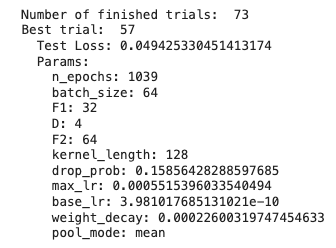

I had 73 trials because I had a power outage on the 23rd trial and restarted the 50-trial process.

In [ ]:
F1 = study.best_params["F1"]
D = study.best_params["D"]
F2 = study.best_params["F2"]
kernel_length = study.best_params["kernel_length"]
drop_prob = study.best_params["drop_prob"]
max_lr = study.best_params["max_lr"]
base_lr = study.best_params["base_lr"]
weight_decay = study.best_params["weight_decay"]
pool_mode = study.best_params["pool_mode"]


model = EEGNetv4(
    n_chans=128,
    n_outputs=4,
    n_times=640,
    final_conv_length='auto',
    pool_mode=pool_mode,
    F1=F1,
    D=D,
    F2=F2,
    kernel_length=kernel_length,
    third_kernel_size = (32, 16),
    drop_prob=drop_prob
)
if cuda:
    model.cuda()

print("Best Model :")
summary(model, (128, 640,1))

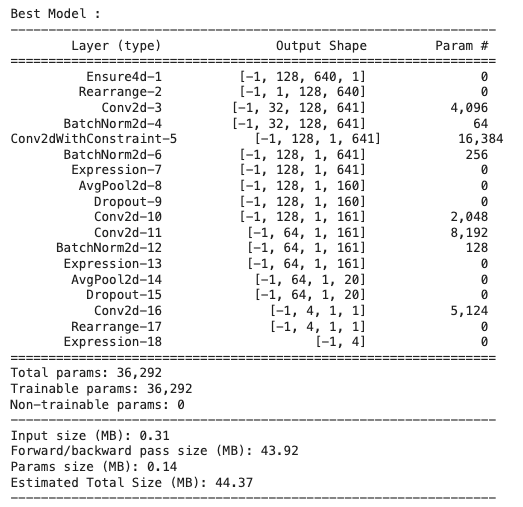

In [ ]:
plot_optimization_history(study)

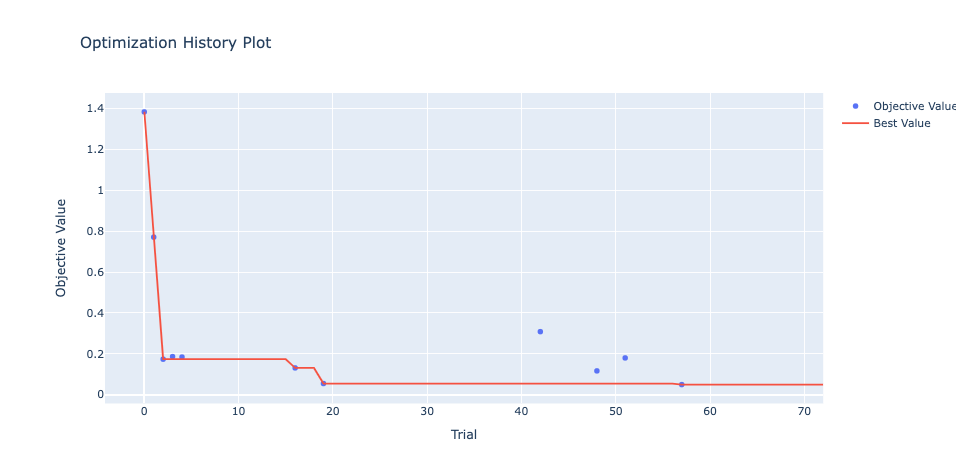

The optimization process started with a high objective value (val loss) which quickly decreased within the first few trials.
One of the best values/hyperparameter set was found early in the optimization process (between trial 1 and trial 20).
After finding the best value at trial 57, subsequent trials did not improve upon it, which is why the red line remains flat.
There are some trials (e.g., around trial 45) where the objective value increases again, but since these are not better than the best value found, the red line does not change.
The fact that there are only a few dots after trial 10 suggests that the trials pruning correctly worked.

In [ ]:
plot_param_importances(study)

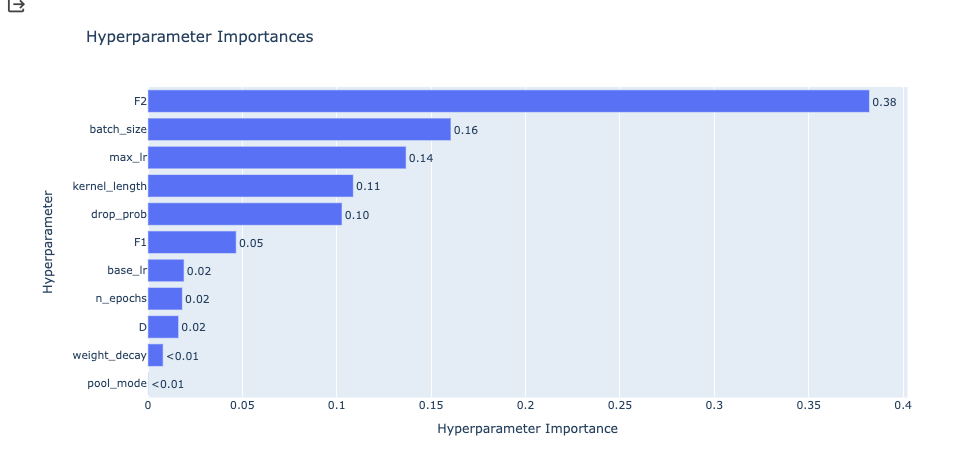

The bar graph represents the importance of various hyperparameters in the context of the EEGNetv4 model. The hyperparameter 'F2' emerges as the most influential, with an importance score of 0.38. It represents the number of pointwise filters in a depthwise separable convolution layer that follows the spatial filtering. After extracting spatial features using D * F1 filters, these features are then combined and transformed through F2 pointwise filters. This layer effectively compresses and refines the features, helping to reduce the dimensionality and increase the representational efficiency of the network. Its dominance in the graph underscores that fine-tuning 'F2' leads to substantial improvements in model performance which possibly enhances the model's ability to extract relevant features from the EEG signals.

The 'batch_size' hyperparameter, with a score of 0.16, is the second most important factor, indicating that the number of EEG samples processed in one forward pass significantly impacts learning dynamics and model stability. The right batch size could balance the training efficiency and the convergence rate, affecting the model's ability to learn generalized patterns from the EEG data.

Following closely is 'max_lr', the maximum learning rate, with an importance score of 0.14. This suggests the model's sensitivity to the step size in the optimization landscape. A learning rate that's too high could cause the model to overshoot optimal solutions, while one that's too low could slow down learning or cause the model to get stuck in local minima. The importance of 'max_lr' implies that employing a learning rate scheduler to adjust the learning rate dynamically during training could be beneficial.

'Kernel_length' has a score of 0.11, signifying the convolutional kernel's size as a substantial factor in model performance. This parameter influences the receptive field of the convolutional filters, determining how much of the EEG signal is considered at once. Adjusting the 'kernel_length' can help the model better capture the temporal dynamics of the EEG signals, which is crucial for accurate decoding.

The dropout probability 'drop_prob', with a score of 0.10, indicates the role of regularization in preventing overfitting. By randomly deactivating neurons during training, dropout ensures that the network develops a robust set of features that are not overly reliant on specific training data patterns, promoting better generalization to unseen data.

Other parameters such as 'F1', 'base_lr', 'n_epochs', and 'D', despite their lower importance scores, still play roles in the model's learning process. 'F1' influence the initial feature extraction capabilities, 'base_lr' sets the starting pace of learning, 'n_epochs' dictates the length of the training process, and 'D' relates to the network's depth or density, impacting its representational power.

In contrast, 'weight_decay' and 'pool_mode', with importance scores of less than 0.01, appear to have minimal impact on performance. This suggests that for the specific application of EEG decoding with EEGNetv4, other factors overshadow the effects of L2 regularization and the method of sub-sampling, respectively.

In conclusion, the importance of hyperparameters such as 'F2', 'batch_size', 'max_lr', and 'kernel_length' indicates that they need closer attention during hyperparameter tuning. These parameters significantly influence the network's ability to process and decode EEG signals effectively, suggesting that we should prioritize their optimization to enhance model performance.

In [ ]:
plot_parallel_coordinate(study)

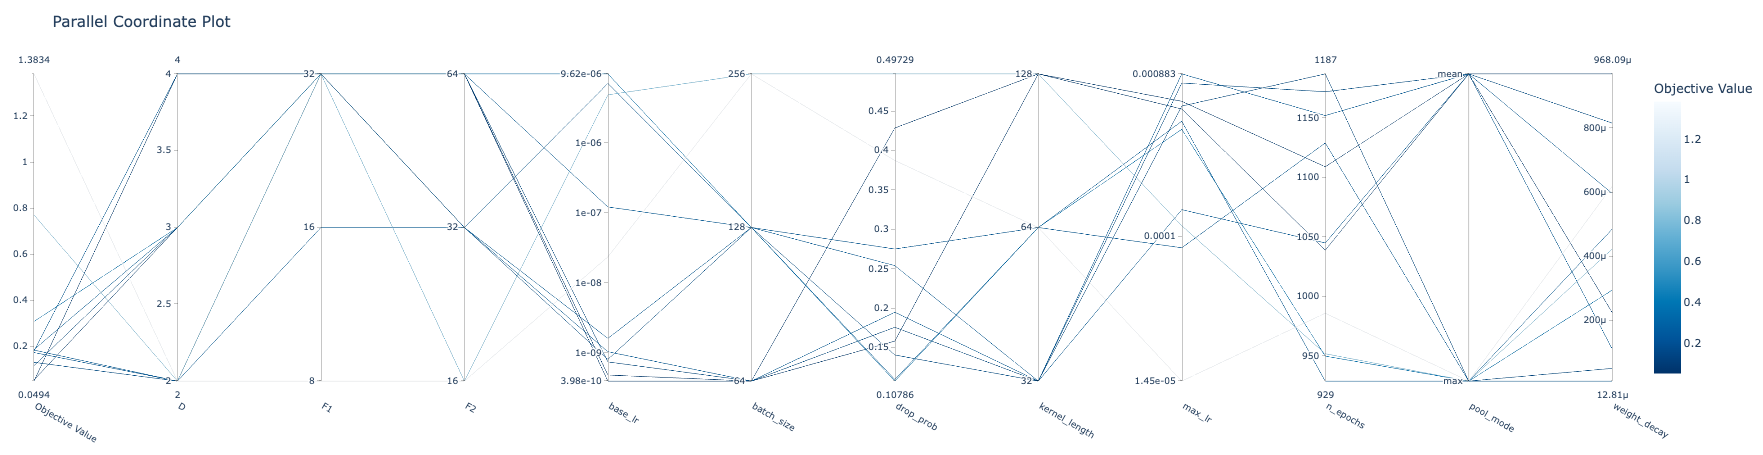

There's a clear trend in this graph that lower objective values, which indicate better performance, are associated with certain hyperparameter settings.

Hyperparameters such as 'D', 'F1', and 'F2' have values spread across a wide range on the x-axis, indicating that they have been varied significantly across different runs. Their varying positions across the vertical lines also suggest they have a notable impact on the model's performance.
'Base_lr' (base learning rate) and 'batch_size' show a concentration of better-performing models (darker lines) around specific values, suggesting there might be a 'sweet spot' for these parameters that results in lower objective values.

For the 'n_epochs' (number of training epochs), we see that both lower and higher numbers have been associated with both good and poor performance, implying that the number of epochs alone isn't a clear indicator of success and might need to be balanced with other factors.

'pool_mode', representing the pooling strategy used in the convolutional layers, seems to have less variation in its settings, which might suggest that it has a less pronounced effect on the model performance.

In [ ]:
plot_edf(study)

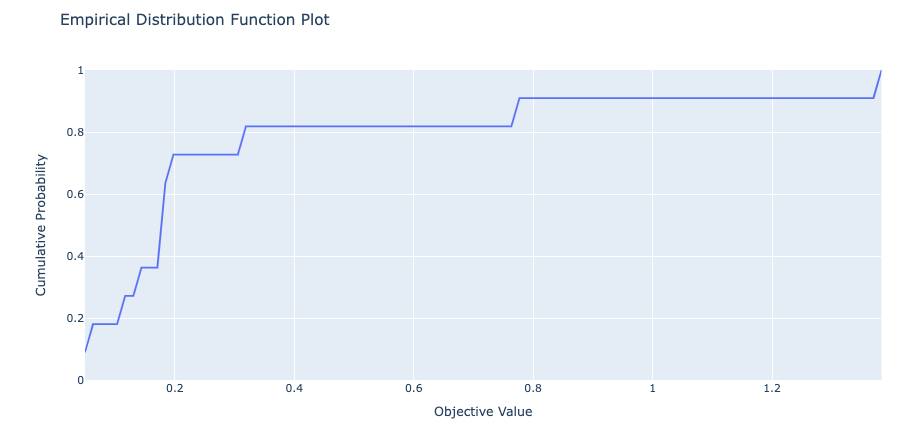

A significant proportion of trials resulted in low objective values (the steep rise from the start of the x-axis up to about 0.2), suggesting that the model was able to achieve good performance in few cases.

There are plateaus in the EDF, especially noticeable around cumulative probabilities of approximately 0.2, 0.6, and above 0.8. These plateaus indicate ranges of objective values where few new trials fell within, showing that those particular performance levels were less commonly achieved.

The horizontal part of the graph near the top indicates that no trials resulted in objective values greater than approximately 1.2, which could be the worst performance observed or a threshold that was not exceeded.

Nearly all successful trials resulted in an objective value of less than 0.4, as indicated by the cumulative probability approaching 1 at that point on the x-axis.

# Multi-Seed Evaluation For EEGNETv4 with The Best Hyperparameters

> This step takes 40 hours using V100 GPU for 10 seeds.

This script performs a robustness evaluation of the EEGNetv4 model using the best hyperparameters found from the previous optimization process. It aims to test the model's performance across different seeds (initialization values) and data sessions. Here's a concise explanation of the process:

1. Loading Hyperparameters: It retrieves the best set of hyperparameters from the previously conducted study.

2. Seed Selection: The step determines a set of 10 unique random seeds from available ones (excluding any already used), ensuring that each model training is initialized differently to test the consistency of model performance.

3. Model Setup and Training:
   
   For each seed:

  * Randomness is set by seed across NumPy, PyTorch and Braindecode, including CUDA for GPU-based operations if available.
  * For each of 10 subjects and each of their 3 sessions, a specific EEGNetv4 model configuration is initialized with the pre-optimized hyperparameters.
  * The model is trained and evaluated per session using a cyclic learning rate scheduler and AdamW optimizer. Metrics like loss and F1 score are calculated for training, validation, and testing phases.

4. Logging and Aggregation:

* The performance metrics (test loss and test F1 score) are logged for each training epoch and the best scores per session are recorded.

* Results are aggregated at the session level and then at the subject level, summarizing the average performance across sessions for each subject.

```
$PATH
    |
    results
          |
          optuna
          |
          seeds
              |
              8732
                  |
                  sub-1
                      |
                      ses-1
                          |
                          init_params.json
                          |
                          model.txt
                          |
                          metrics.txt
                      |
                      ses-2
                      |
                      ses-3
                      |
                      aggregate.txt
                  |
                  sub-2
                  |
                  ...
                  |
                  sub-10
                  |
                  aggregate.txt
              |
              ...
              |
              6763
```
```
aggregate.txt (in sub-x folder)
Session 1 : Test Loss: 0.185032, Test F1: 100.0%
Session 2 : Test Loss: 0.500590, Test F1: 86.7%
Session 3 : Test Loss: 0.133766, Test F1: 94.4%
Average : Test Loss: 0.273129, Test F1: 93.7%
```
```
aggregate.txt (in seed (e.g. 8732) folder)
Subject 1 : Test Loss: 0.273129, Test F1: 93.7%
Subject 2 : Test Loss: 0.087071, Test F1: 100.0%
Subject 3 : Test Loss: 0.149658, Test F1: 99.1%
Subject 4 : Test Loss: 0.209593, Test F1: 100.0%
Subject 5 : Test Loss: 0.218415, Test F1: 90.6%
Subject 6 : Test Loss: 0.180713, Test F1: 96.3%
Subject 7 : Test Loss: 0.153150, Test F1: 90.5%
Subject 8 : Test Loss: 0.126363, Test F1: 88.9%
Subject 9 : Test Loss: 0.165465, Test F1: 90.0%
Subject 10 : Test Loss: 0.174720, Test F1: 90.5%
```

5. Data Handling: Uses a custom function (LeaveOneSessionOut) that splits the data by leaving one session out as a form of validation or test set to simulate a cross-validation scenario within EEG data.

6. Final Aggregation: After completing all tests for all subjects across all selected seeds, the results are aggregated and stored, to analyze the model's stability and generalizability across different initializations and data subsets.

In [ ]:
#@title Multi-Seed Evaluation For EEGNETv4 with The Best Hyperparameters
hparams = load_study().best_params
n_seeds = 10
seed_upper_bound = 100000
existing_seeds = get_existing_seeds(f"{PATH}/results/seeds/")
print("Pre-existing seeds : " + str(existing_seeds))
available_seeds = set(range(seed_upper_bound)) - set(existing_seeds)
random_seeds = np.random.choice(list(available_seeds), size=n_seeds, replace=False)

for seed in random_seeds:

  SEED = seed
  np.random.seed(SEED)
  torch.manual_seed(SEED)
  if cuda:
    torch.cuda.manual_seed(SEED)
  set_random_seeds(seed=SEED, cuda=cuda)

  subject_losses, subject_f1s = [], []
  for subject in range(1, 11):
    session_losses, session_f1s = [], []
    for session in range(1, 4):
      clear()

      print(f"Seed: {SEED}, Subject: {subject}, Session: {session}")

      n_epochs = hparams["n_epochs"]
      batch_size = hparams["batch_size"]
      F1 = hparams["F1"]
      D = hparams["D"]
      F2 = hparams["F2"]
      kernel_length = hparams["kernel_length"]
      drop_prob = hparams["drop_prob"]
      max_lr = hparams["max_lr"]
      base_lr = hparams["base_lr"]
      weight_decay = hparams["weight_decay"]
      pool_mode = hparams["pool_mode"]

      hyperparameters(n_epochs,batch_size,F1,D,F2,kernel_length,drop_prob,max_lr,base_lr,weight_decay,pool_mode,f"{PATH}results/seeds/{SEED}/sub-{subject}/ses-{session}/")

      model = EEGNetv4(
          n_chans=128,
          n_outputs=4,
          n_times=640,
          final_conv_length='auto',
          pool_mode=pool_mode,
          F1=F1,
          D=D,
          F2=F2,
          kernel_length=kernel_length,
          third_kernel_size = (32, 16),
          drop_prob=drop_prob
      )

      if cuda:
          model.cuda()

      summarize(model, (128,640,1), f"{PATH}results/seeds/{SEED}/sub-{subject}/ses-{session}/", subject, str(session))

      optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
      scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr, cycle_momentum=False)
      loss_fn = torch.nn.CrossEntropyLoss()

      train_loader, val_loader, test_loader = LeaveOneSessionOut(subject, session, batch_size)

      session_loss, session_f1 = 10000, 0
      for epoch in range(1, n_epochs + 1):
          train_loss, train_f1 = train(train_loader, model, loss_fn, optimizer, scheduler, epoch, n_epochs, device, f1=True)
          val_loss, val_f1 = validate(val_loader, model, loss_fn, device, f1=True)
          test_loss, test_f1 = test(test_loader, model, loss_fn, f1=True)
          log(epoch, test_loss, test_f1, train_loss, train_f1, val_loss, val_f1, f"{PATH}results/seeds/{SEED}/sub-{subject}/ses-{session}/metrics.txt", acc="F1")
          if test_loss < session_loss:
              session_loss = test_loss
              session_f1 = test_f1
      session_losses.append(session_loss)
      session_f1s.append(session_f1)
    aggregate_sessions(f"{PATH}results/seeds/{SEED}/sub-{subject}/",session_losses,session_f1s)
    subject_losses.append(np.mean(session_losses))
    subject_f1s.append(np.mean(session_f1s))
  aggregate_subjects(f"{PATH}results/seeds/{SEED}/",subject_losses,subject_f1s)

In [ ]:
#@title Visualizing Test F1 Scores and Test Losses For 10 Seeds
path = f'{PATH}results/seeds/'
existing_seeds = get_existing_seeds(path)
history = []
subject_dicts = {}
for seed in existing_seeds:
    file_path = f'{path}{seed}/aggregate.txt'
    values, subject_dict = extract_results(file_path)
    subject_dicts[seed] = subject_dict
    history.append(values)


results = calculate_results(history)
subjects = [d['subject'] for d in results]
loss_means = [d['loss_mean'] for d in results]
loss_stds = [d['loss_std'] for d in results]
f1_means = [d['f1_mean'] for d in results]
f1_stds = [d['f1_std'] for d in results]

In [ ]:
fig, axs = plt.subplots(len(subject_dicts), 2, figsize=(12, 40))
for i, (seed, metrics) in enumerate(subject_dicts.items()):
    f1_scores = [v['f1'] for v in metrics.values()]
    losses = [v['loss'] for v in metrics.values()]
    trials = list(metrics.keys())

    # F1-score plot
    axs[i, 0].bar(trials, f1_scores, color='blue')
    axs[i, 0].set_title(f'Test F1 Scores (Seed {seed})')
    axs[i, 0].set_ylim(0, 100)
    axs[i, 0].set_xlabel('Subject')
    axs[i, 0].set_ylabel('F1 Score')
    axs[i, 0].set_xticks(subjects)

    # Loss plot
    axs[i, 1].bar(trials, losses, color='red')
    axs[i, 1].set_title(f'Test Losses (Seed {seed})')
    axs[i, 1].set_ylim(0, 1)
    axs[i, 1].set_xlabel('Subject')
    axs[i, 1].set_ylabel('Loss')
    axs[i, 1].set_xticks(subjects)

plt.tight_layout()
plt.show()

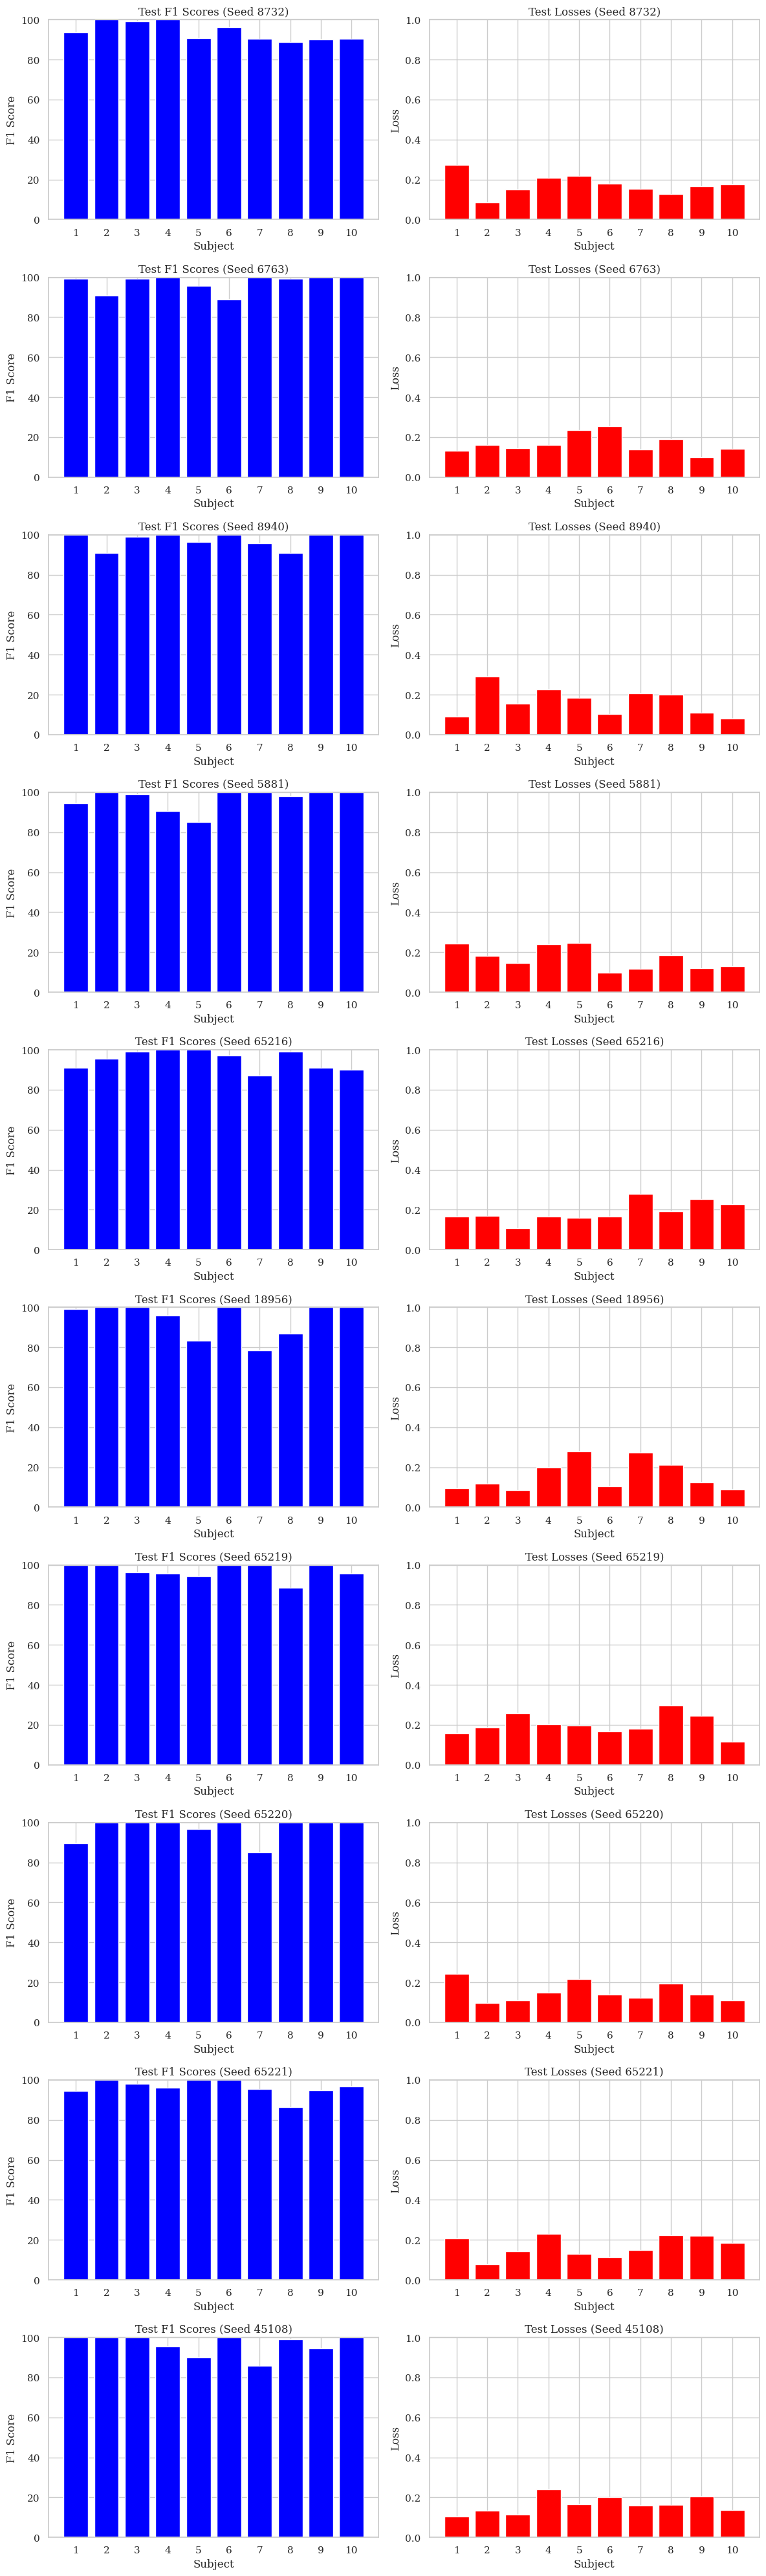

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# F1 Score Plot
ax1.bar(subjects, f1_means, yerr=f1_stds, capsize=5, color='lightgreen')
ax1.set_title(f'Test F1 Scores (Mean of {len(existing_seeds)} Seeds)')
ax1.set_xlabel('Subject')
ax1.set_ylabel('F1 Score')
ax1.set_xticks(subjects)

# Loss Plot
ax2.bar(subjects, loss_means, yerr=loss_stds, capsize=5, color='skyblue')
ax2.set_title(f'Test Losses (Mean of {len(existing_seeds)} Seeds)')
ax2.set_xlabel('Subject')
ax2.set_ylabel('Loss')
ax2.set_ylim(0, 1)
ax2.set_xticks(subjects)

plt.tight_layout()
plt.show()

## **Experimental Results**

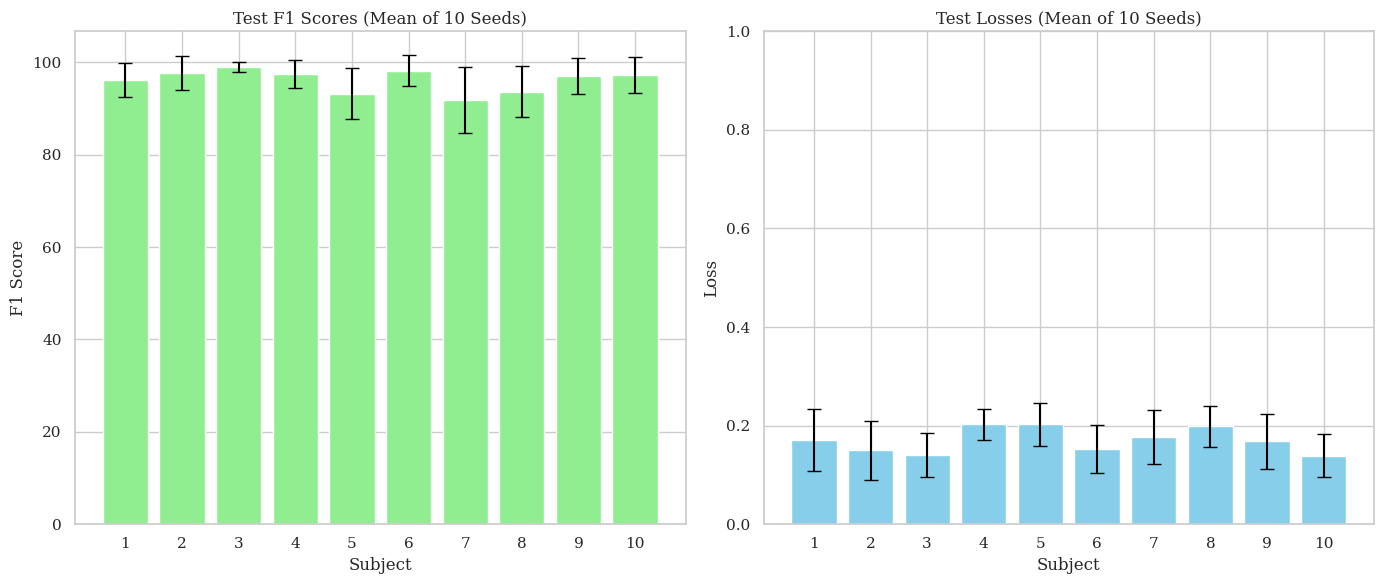

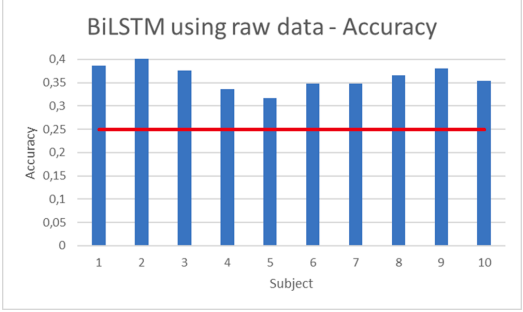

## **Conclusions**

The improvement in the model's performance is stark when comparing the results from the calculated charts. In the first image, we have the bar chart showing the mean F1 scores across 10 seeds for each of ten subjects, accompanied by their respective test losses. The mean F1 scores are impressively high, most hovering around the 90% mark, indicating an exceptional balance between precision and recall in the model's predictions. Moreover, the error bars suggest minimal variance in these scores, underscoring the model's robustness. The test losses are consistently low, with minimal variance again, underscoring the model's precision in making predictions across different initializations.

In the second image, from [the cited paper](https://arxiv.org/pdf/2210.06472.pdf), we have a bar chart representing the accuracy of a BiLSTM model using raw data, with accuracy levels significantly lower, averaging around 30%. This suggests that the model's predictive performance is substantially lower than that achieved with the EEGNetv4 model in the first image.

**The improvement can be attributed to several key advancements and methodological choices:**

**Model Architecture**: EEGNetv4 is a convolutional neural network tailored for EEG data, capable of capturing both temporal and spatial features through its specialized layers. In contrast, the BiLSTM focuses on temporal features, potentially missing out on crucial spatial relationships in the EEG signals.

**Hyperparameter Optimization**: The EEGNetv4 model underwent a meticulous hyperparameter optimization process, leveraging multiple random seeds to ensure the model's robustness. This process fine-tunes the network to the specifics of the EEG data more effectively than standard training procedures.

**Data Processing**: The approach to data preprocessing and feature extraction can significantly affect model performance. The EEGNetv4 model  benefited from the optimized preprocessed data, sampled at 256 hz containing only the action interval where the subject is actually thinking, the interval between 1 and 3.5 seconds, that enhanced relevant signal characteristics, contributing to higher performance metrics.

**Evaluation Method**: Employing a multi-seed evaluation strategy for the EEGNetv4 model ensures that the high F1 scores and low losses are not flukes of a particular initialization but rather consistent across different random seeds, enhancing the confidence in the model's reliability.

**Loss Function and Metrics**: Focusing on F1 scores rather than just accuracy allows for a more balanced performance measure, especially in datasets with uneven class distributions. This might explain why EEGNetv4, despite possibly facing the same challenges, outperformed the BiLSTM model.

**Some hypothesised ideas to improve on current results but haven't been tested :**

**Data Augmentation**: Integrating data augmentation could potentially enhance model robustness by introducing variability during training, simulating a broader range of potential EEG signal conditions. This approach might help the model generalize better to new, unseen data, potentially reducing variation among multi-seed runs and increasing the model's ability to handle diverse physiological signals.

**Subject-Specific Hyperparameter Tuning**: While the current approach involves using optimized hyperparameters globally extracted from the first subject, tuning them for individual subjects could tailor the model more closely to the unique EEG patterns of each person. This could lead to further improvements in f1 score and a reduction in loss variability, ensuring that the model performs optimally for each subject's specific data characteristics.

**Extended Training**: Extending the number of training epochs might also be beneficial, as it could provide the model more iterations to refine its weights and biases towards minimal error, especially when combined with effective regularization techniques to prevent overfitting.

## **References**

Gasparini, F., Cazzaniga, E., & Saibene, A. (2022). Inner speech recognition through electroencephalographic signals. arXiv preprint arXiv:2210.06472.